In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# Plotting settings
a_min = 1e-3
a_max = 1
margin = 1.3

# Linear predictions

In [2]:
# from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [3]:
import sympy as sym

import numpy as np
from sympy import symbols, sqrt, lambdify, Function, solve, Derivative, init_printing, exp, pi, sympify, nsimplify, Float, N
init_printing()
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline

In [4]:
plt.style.use('./my_style.py')
import matplotlib.ticker as mticker

from cycler import cycler
import matplotlib.cm     as cm

In [5]:
#Symbolic variables
x, y, mu, k, E_diffa= symbols(r' x, y, \mu, k, E_a')
a= symbols('a', positive=True)
D= Function('D')
E = Function('E')(a)

In [6]:
Om0  = symbols('O_m0')

In [7]:
# h =  0.6774
Om0_val = nsimplify(0.3089)
# Om0 = 0.3

Ol0 = 1- Om0_val
H0_hinvMpc= 1#1/2997.92458

In [8]:
z_ini = 999
z_fin = 0

a_ini = 1/(1+z_ini)
a_fin = 1/(1+z_fin)

z_eval = np.array([ 1.65,1.4,1.2,1])
a_eval = 1/(1+z_eval)

In [9]:
H = H0_hinvMpc*E
H_LCDM = H0_hinvMpc*sqrt(Om0_val*a**(-3) + Ol0)
H_LCDM_Or = H0_hinvMpc*sqrt(Om0_val*a**(-3) + Ol0+ 8*10**(-5)*a**(-4))
H_conf = H*a
Om = Om0_val*a**(-3)
Ol = Ol0

# Ben's data

### Background

In [10]:
header_str = 'a,  H_MG,  H_LCDM, H_MG/H_LCDM,  aH dH/da / H0^2 ,  phi , d phi/ dlna'
header = [s.strip(' ')for s in header_str.split(',')]

In [11]:
df_Ben_BG = pd.DataFrame(np.loadtxt('./Data/Background/background_k01_glam.dat'), columns=header).set_index('a')

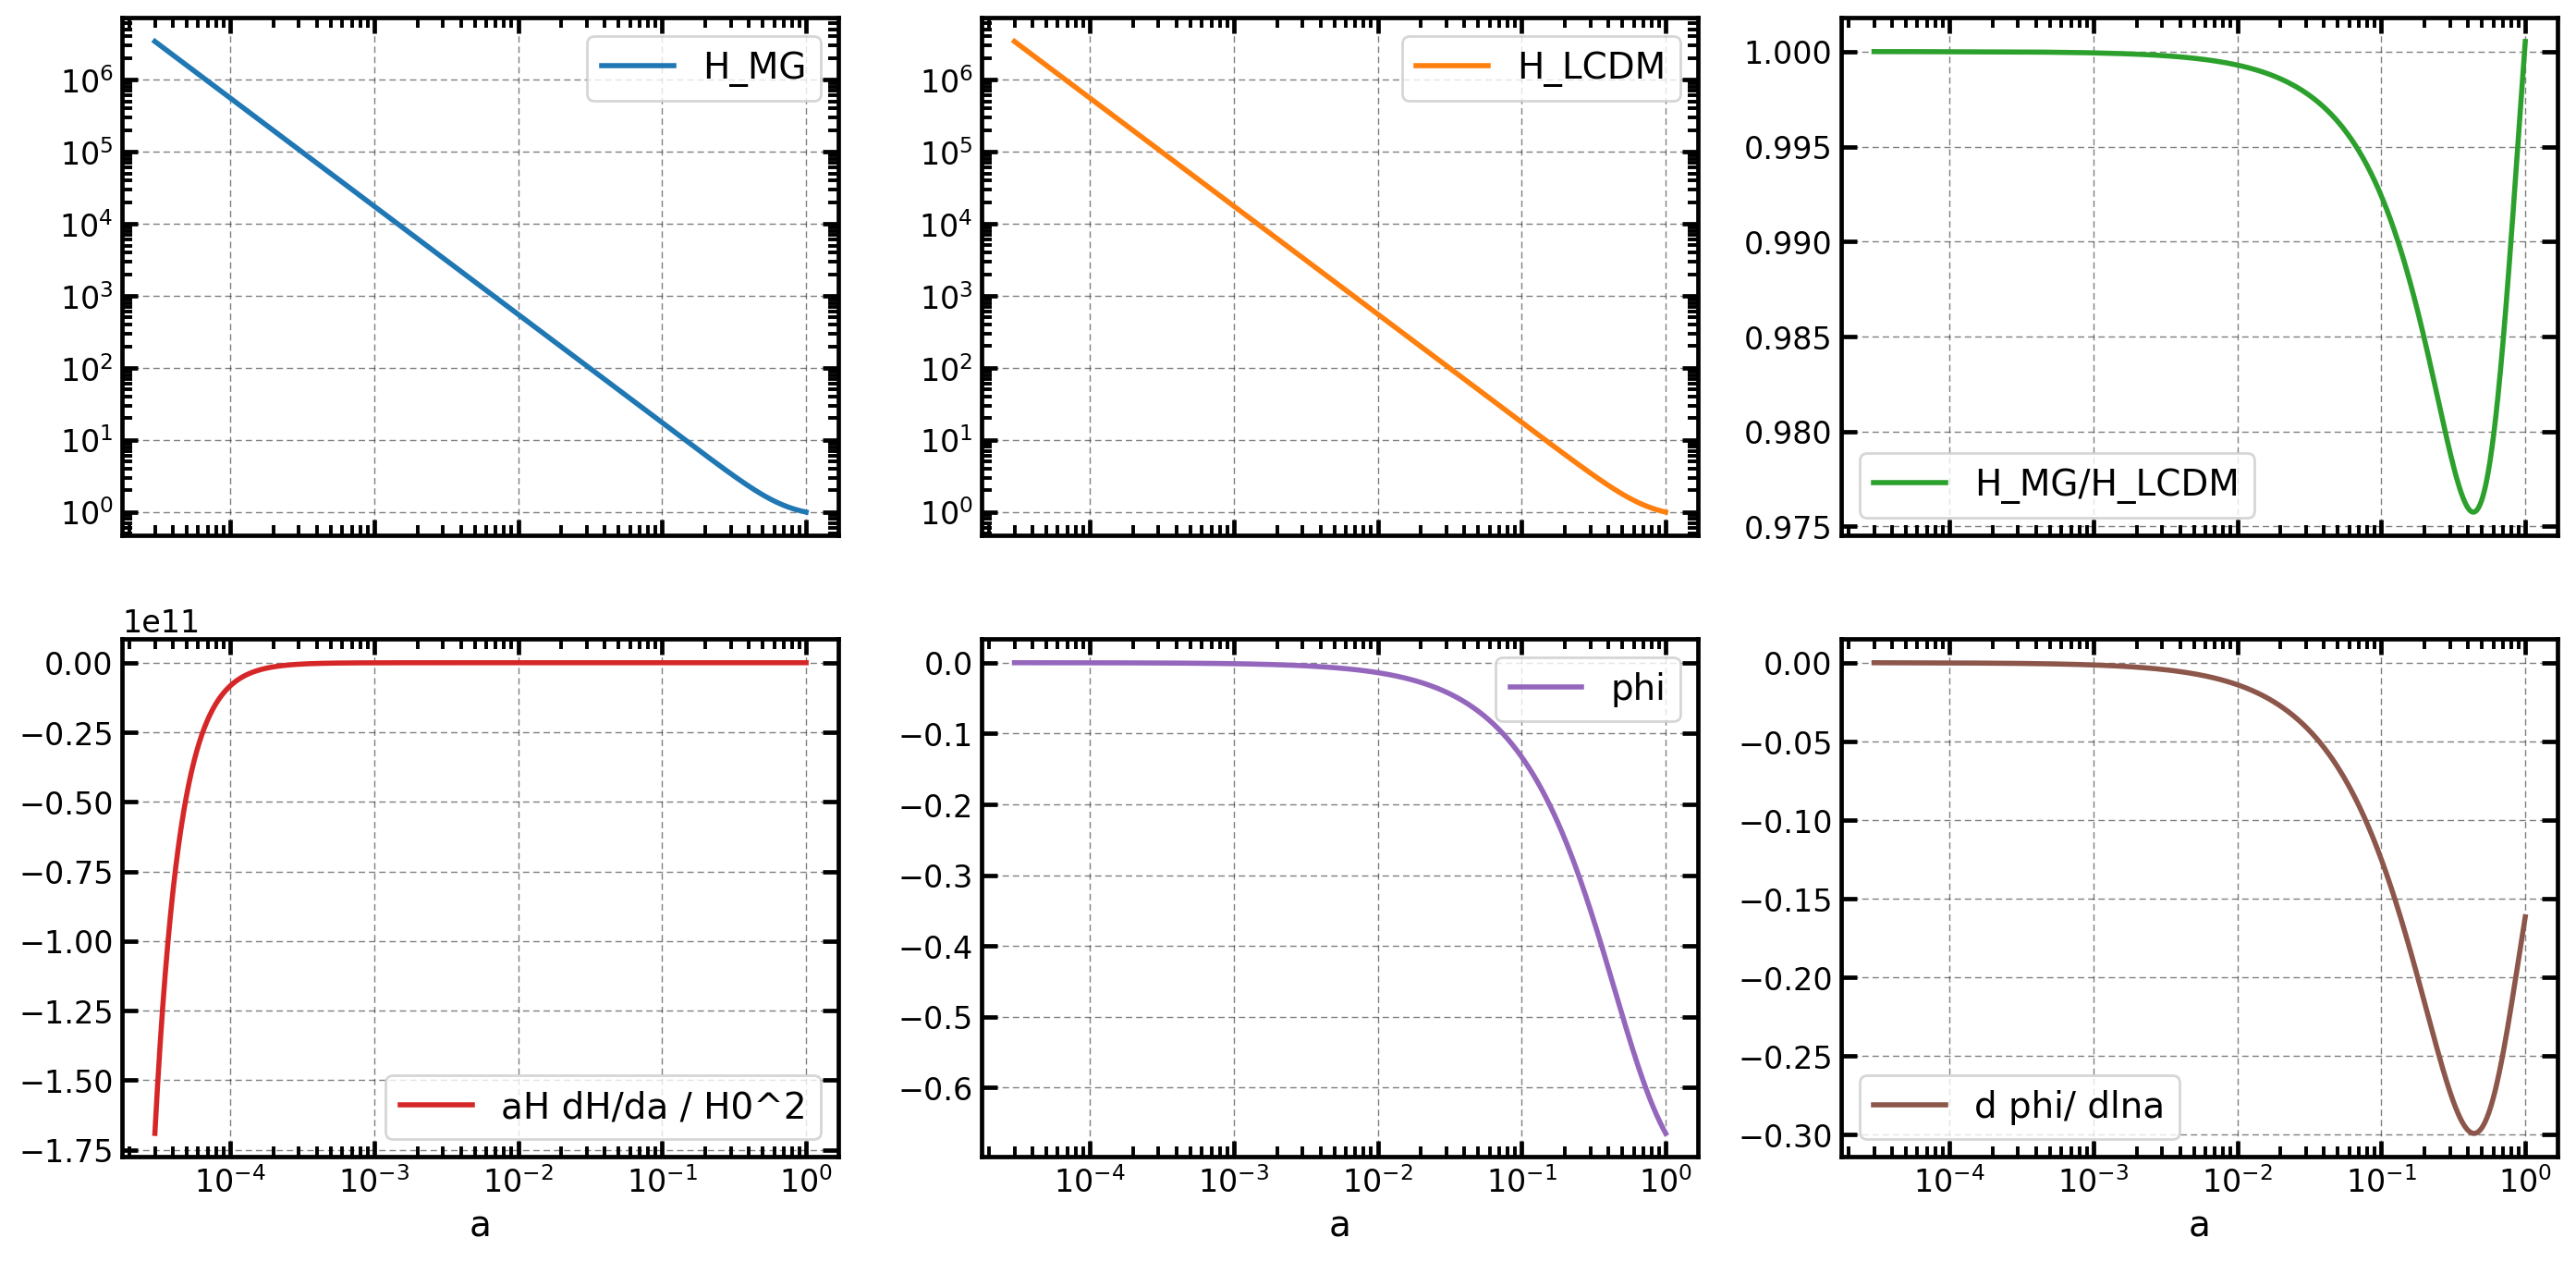

In [12]:
fig, axs = plt.subplots(2,3, figsize=(17,8), sharex=True)
df_Ben_BG.plot(ax=axs, subplots=True)

for ax in axs.flatten():
    ax.set_xscale('log')
    if (ax.get_ylim()[1]>10) and (ax.get_ylim()[0]>-1e9):
        ax.set_yscale('log')

In [13]:
a_vals = df_Ben_BG.index

phi_kmou = InterpolatedUnivariateSpline(a_vals, df_Ben_BG['phi'])
phi_diffa_kmou = phi_kmou.derivative()
E_kmou = InterpolatedUnivariateSpline(a_vals, df_Ben_BG['H_MG'])
E_diffa_kmou = E_kmou.derivative()
phi_p_kmou = lambda a: a*(a*E_kmou(a)*H0_hinvMpc)*phi_diffa_kmou(a)

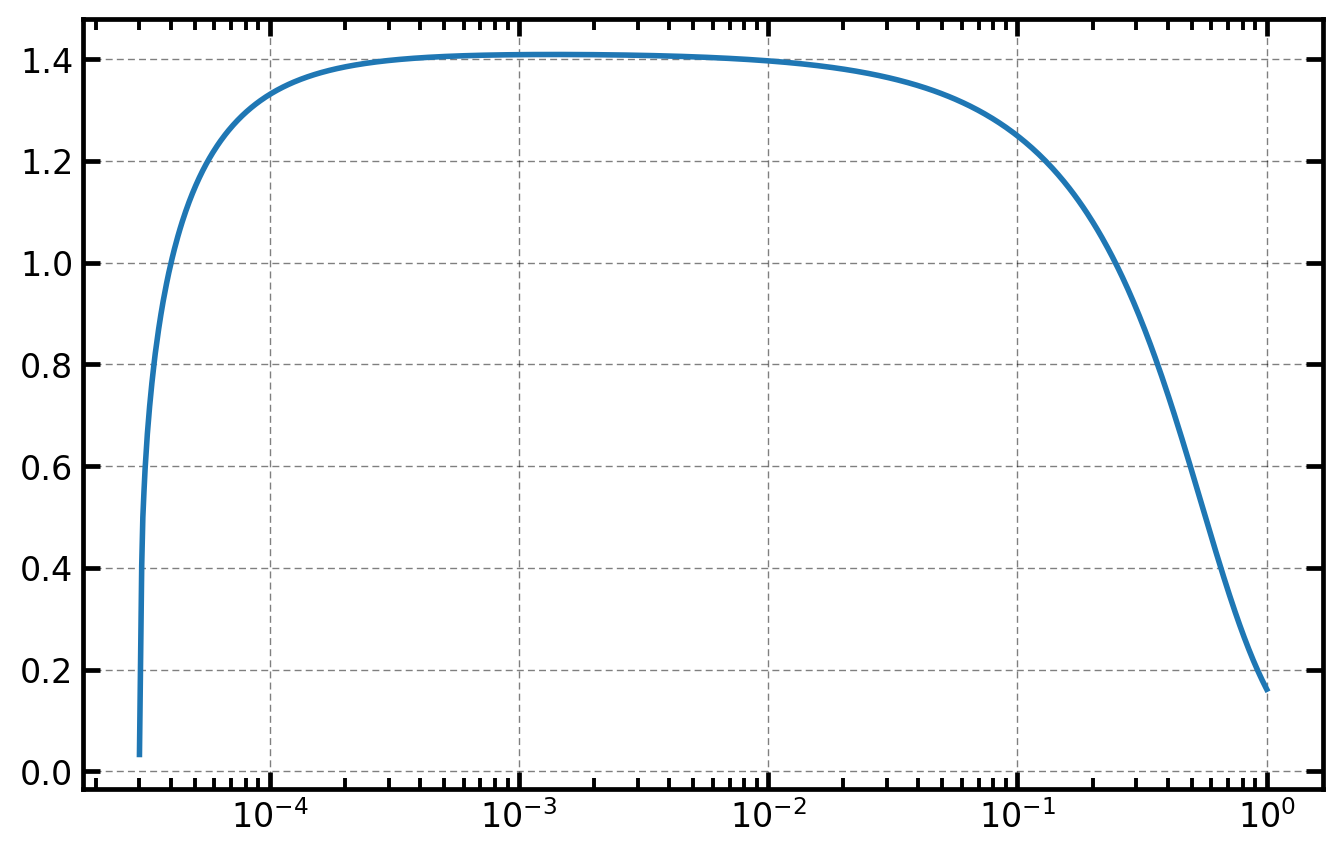

In [14]:
plt.semilogx(abs(df_Ben_BG['d phi/ dlna']/df_Ben_BG.index))

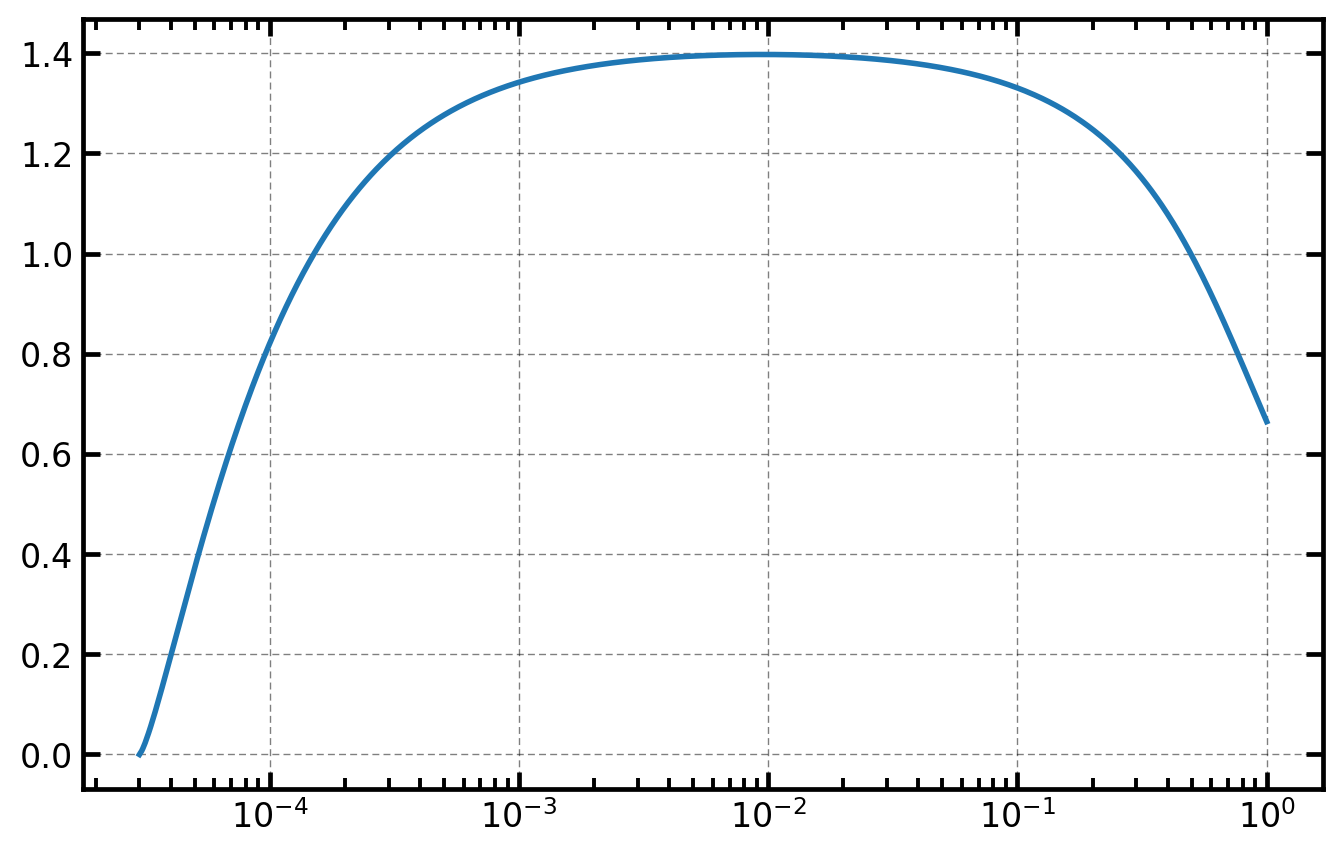

In [15]:
plt.semilogx(-(df_Ben_BG['phi']/df_Ben_BG.index))

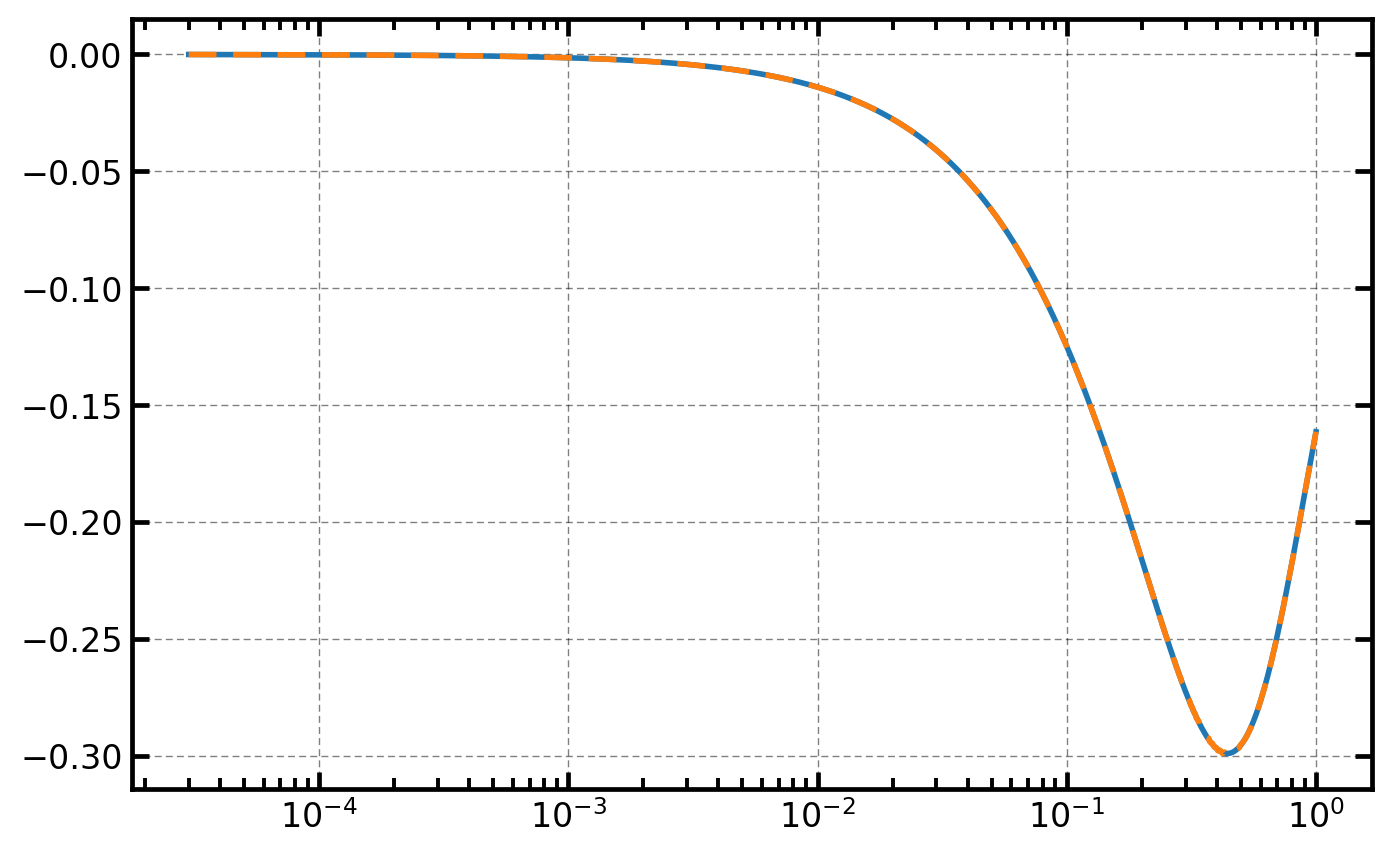

In [16]:
plt.semilogx(df_Ben_BG['d phi/ dlna'])
plt.semilogx(a_vals, a_vals*phi_diffa_kmou(a_vals), '--')

# Expansion

In [17]:
E_vals_LCDM = lambdify((a),H_LCDM/H0_hinvMpc)(df_Ben_BG.index)

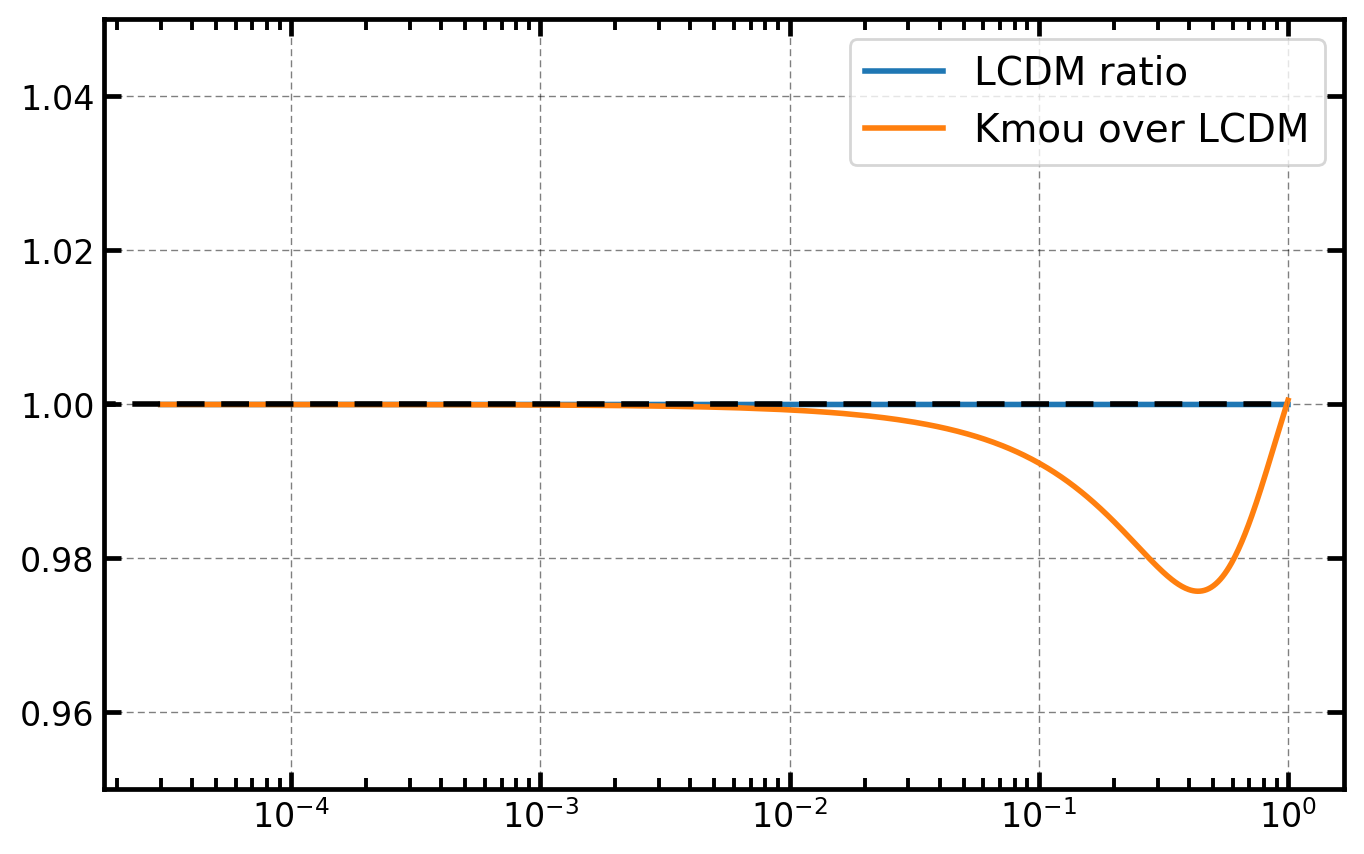

In [18]:
plt.semilogx(df_Ben_BG['H_LCDM']/E_vals_LCDM, label='LCDM ratio')
plt.semilogx(df_Ben_BG['H_MG']/E_vals_LCDM, label='Kmou over LCDM')
plt.ylim(0.95,1.05)
plt.hlines(1, 0, 1, colors='k', linestyles='--')
plt.legend();

# Background

#### $k$-mouflage

The growth equation for the k-mouflage model in the Einstein frame reads:
$$D_{1}^{\prime \prime}+\left[\frac{a^{\prime}}{a}+\frac{\mathrm{d} \ln A(\varphi)}{\mathrm{d} \varphi} \varphi^{\prime}\right] D_{1}^{\prime}-4 \pi G \bar{\rho}_{\mathrm{m}}(a) a^2 A(\bar{\varphi})\left[1+\frac{2 \beta_{\mathrm{Kmo}}^2}{K_X(\bar{X})}\right] D_{1}=0$$
where the conformal factor is given by 
$$A(\varphi)= \exp \left(\beta_{\mathrm{Kmo}} \varphi\right),$$
$$\frac{\mathrm{d} \ln A(\varphi)}{\mathrm{d} \varphi}=\beta_{\mathrm{Kmo}}.$$
Here we focus on the model:
$$K(X)=-1+X+K_0 X^n$$
with $n=2$ and $K_0=1$. Furthermore, we fix $\beta_{\mathrm{Kmo}}=0.2$. Hence, we have 
$$A(\varphi)=\exp \left(0.2 \varphi\right),$$
$$K_X(\bar{X}) = 1 + 2\bar{X} = 1 + \frac{\bar{\varphi}^{\prime 2}}{\lambda^2 a^2 H_0^2}.$$
where $\lambda=1.476$ is necessary to recover the correct value of $H_0$ today.

In [24]:
symbols(r'\phi, \phi^{\prime}, \phi^{\prime\prime}, X')

In [25]:
# Define kmouflage quantities
beta = 0.2
phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
phi = Function(r'\phi')(a)
phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
A = exp(beta*phi)
rho_m = Om*3*H0_hinvMpc**2/(8*pi*G) # convert rho_m into Om
phi_d = phi_p/a
phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf
phi_p_ofa = a*H_conf*phi.diff(a)
phi_pp_ofa = a*H_conf*(phi_p_ofa).diff(a)

n=2
K0=1
lamb= symbols(r'\lambda')
K = (-1 + X + K0*X**n)
K_x = K.diff(X)
K_xx = K_x.diff(X)
X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_x_bar = K_x.subs(X, X_bar)
K_xx_bar = K_xx.subs(X, X_bar)

# mu_kmou = 1+ 2*beta**2/(K_x_bar)

We use that:
- $\rho_m = 3 \Omega_m H_0^2 /(8 \pi G)$
- $\frac{d}{dt} = \frac{d}{a d\tau}$
- $\dot{\phi} = \phi^{\prime}/a$
- $\ddot{\phi} = \frac{d}{dt}(\phi^{\prime}/a) = \frac{1}{a^2}\phi^{\prime\prime} - \frac{1}{a^2} \phi^{\prime} \mathcal{H}$

and as above:
$$\frac{d}{d\tau} = a \mathcal{H} \frac{d}{da}$$

# Test solver

We first construct a solver that uses 3 variables:
- $\phi$
- $\phi_a \equiv \frac{d \phi}{d a}$
- $E_a \equiv \frac{d E}{d a}$

We compare its solutions to Ben's.

In [180]:
# lamb =1.476
lamb_val = nsimplify(5)
lamb =symbols(r'\lambda')
beta=0.2 
n=3 
K0=1
H0_target=1
a_ini=3e-4
a_fin=2

In [181]:
# test increasing precision
import mpmath as mp
mp.dps = 15
mp.prec = 53

In [182]:
phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
phi = Function(r'\phi')(a)
phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
# symbols for system of diff eq
phi_a = symbols(r'\phi_a')

phi_p = a*H_conf*phi.diff(a)
phi_pp = a*H_conf*(phi_p).diff(a)

A = exp(beta*phi)
rho_m = (Om*H0_hinvMpc**2/(8*pi*G/3))#.evalf(30) # convert rho_m into Om
phi_d = phi_p/a
phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf

K = (-1 + X + K0*X**n)
K_x = K.diff(X)
K_xx = K_x.diff(X)
X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_x_bar = K_x.subs(X, X_bar)
K_xx_bar = K_xx.subs(X, X_bar)

kmou_back = ((K_x + 2*X*K_xx)*phi_dd + 3*H*K_x*phi_d + A.diff(phi)*8*pi*G * rho_m).evalf(n=30, subs={Om0:Om0_val})
H_kmou_sq = rho_m/3*8*pi*G*A+(K_x*phi_d**2/3 - lamb**2*K*H0_hinvMpc**2/3) -H**2
# E_kmou = solve(H_kmou_sq.subs(X, X_bar), E)[1]#.subs(phi.diff(a),phi_a)
# E_kmou = solve(H_kmou_sq.subs(X, X_bar), E)[1]#/N(sqrt(2)))*sqrt(2)

In [183]:
# ---------------------------- READ ----------------------------
# The chosen equation to compute the derivative E' has an effect on the solution
E_kmou_a_eq = (((-4*pi*G*A*rho_m - K_x*phi_d**2/2 - lamb**2*H0_hinvMpc**2*K)/3-H**2)/H_conf/H0_hinvMpc).evalf(n=30, subs={Om0:Om0_val})
# E_kmou_a_eq = E_kmou.diff(a)#
# E_kmou_a_eq = E_kmou_a_eq.subs(E, E_kmou)
# H_LCDM = H0_hinvMpc*sqrt(Om+Ol)
# E_kmou_a_eq = (H_LCDM/H0_hinvMpc).diff(a)

In [184]:
# kmou_back = kmou_back.subs(X, X_bar)
# E_kmou_a_eq = E_kmou_a_eq.subs(X, X_bar).expand()

dphia_o_da_sym_eq = solve(kmou_back.subs(phi.diff(a),phi_a),Derivative(phi_a,a))[0]
# ---------------------------- READ ----------------------------
# Substuting E_kmou inside dphia_o_da_sym_eq produces a different results than using the integrated E
# dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E.diff(a), E_kmou_a_eq).subs(X, X_bar).subs(E, E_kmou).subs(phi.diff(a),phi_a)
dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E.diff(a), E_kmou_a_eq).subs(X, X_bar).subs(phi.diff(a),phi_a)

In [185]:
# dphia_o_da_sym_eq = solve(kmou_back.subs(E.diff(a),E_kmou_a_eq).subs(phi.diff(a),phi_a), Derivative(phi_a,a))[0]
dH_o_da_sym_eq = E_kmou_a_eq.subs(X, X_bar).subs(phi.diff(a),phi_a)

In [189]:
dphi_o_da_eq = lambdify((a, phi, phi_a, E), phi_a)
dphia_o_da_eq = lambdify((a, phi, phi_a, E), dphia_o_da_sym_eq.evalf(30, subs={lamb:lamb_val}),
                        modules='mpmath')
dE_o_da_eq = lambdify((a, phi, phi_a, E), dH_o_da_sym_eq.evalf(30, subs={lamb:lamb_val}),
                     modules='mpmath')


def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (dphi_o_da_eq(t,vec[0],vec[1], vec[2]),
            dphia_o_da_eq(t,vec[0],vec[1], vec[2]),
           dE_o_da_eq(t,vec[0],vec[1], vec[2]))

# Compute the solution of the differential equation
H_kmou_sol = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-0.1*a_ini, -1, H_LCDM.subs(a,a_ini)/H0_hinvMpc),
                       dense_output=True, rtol=1e-9,
                       method='LSODA',
                       atol=1e-9
                      )

In [153]:
E_kmou_fun = lambdify((a, phi, phi_a), nsimplify(E_kmou).subs(lamb,lamb_val).subs(Derivative(phi, a), phi_a))
E_kmou_a_fun = lambdify((a, phi, phi_a), nsimplify(E_kmou_a_eq).subs(lamb,lamb_val).subs(Derivative(phi, a), phi_a))

KeyboardInterrupt: 

In [190]:
a_vals = np.linspace(1e-4, 1, 100)
phi_vals = np.logspace(-20, 1, 100)

In [191]:
E_3p55 = np.array([lambdify((a, phi, phi_a), E_kmou.subs(Derivative(phi, a), phi_a))(t,f,f_p) 
                   for t,f,f_p in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1])])

E_3p55_Ben = np.array([lambdify((a, phi, phi_a), E_kmou.subs(Derivative(phi, a), phi_a))(t,f,f_p) for 
                   t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

<lambdifygenerated-101>:2: RuntimeWarning: invalid value encountered in sqrt
  return 3.3740479511421*sqrt(-a**2*(sqrt(0.16087962962963/Dummy_4533**12 + 0.0321770833333333*exp(0.2*_Dummy_4532)/(Dummy_4533**12*a**3) + 0.00165658350694444*exp(0.4*_Dummy_4532)/(Dummy_4533**12*a**6) - 0.0833333333333333/(Dummy_4533**14*a**2) + 0.5/(Dummy_4533**16*a**4) - 1/(Dummy_4533**18*a**6)) + 0.395284707521047/Dummy_4533**6 + 0.0407011487177505*exp(0.2*_Dummy_4532)/(Dummy_4533**6*a**3))**(-0.666666666666667)*sqrt(0.16087962962963/Dummy_4533**12 + 0.0321770833333333*exp(0.2*_Dummy_4532)/(Dummy_4533**12*a**3) + 0.00165658350694444*exp(0.4*_Dummy_4532)/(Dummy_4533**12*a**6) - 0.0833333333333333/(Dummy_4533**14*a**2) + 0.5/(Dummy_4533**16*a**4) - 1/(Dummy_4533**18*a**6)) + 0.166666666666667*a**2*(sqrt(0.16087962962963/Dummy_4533**12 + 0.0321770833333333*exp(0.2*_Dummy_4532)/(Dummy_4533**12*a**3) + 0.00165658350694444*exp(0.4*_Dummy_4532)/(Dummy_4533**12*a**6) - 0.0833333333333333/(Dummy_4533**14*a**2) + 0

KeyboardInterrupt: 

<>:5: SyntaxWarning: invalid escape sequence '\L'
<>:5: SyntaxWarning: invalid escape sequence '\L'
/var/folders/_0/rw1qxx2x3ss_l_mx90qfbv740000gn/T/ipykernel_89328/269781583.py:5: SyntaxWarning: invalid escape sequence '\L'
  axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')


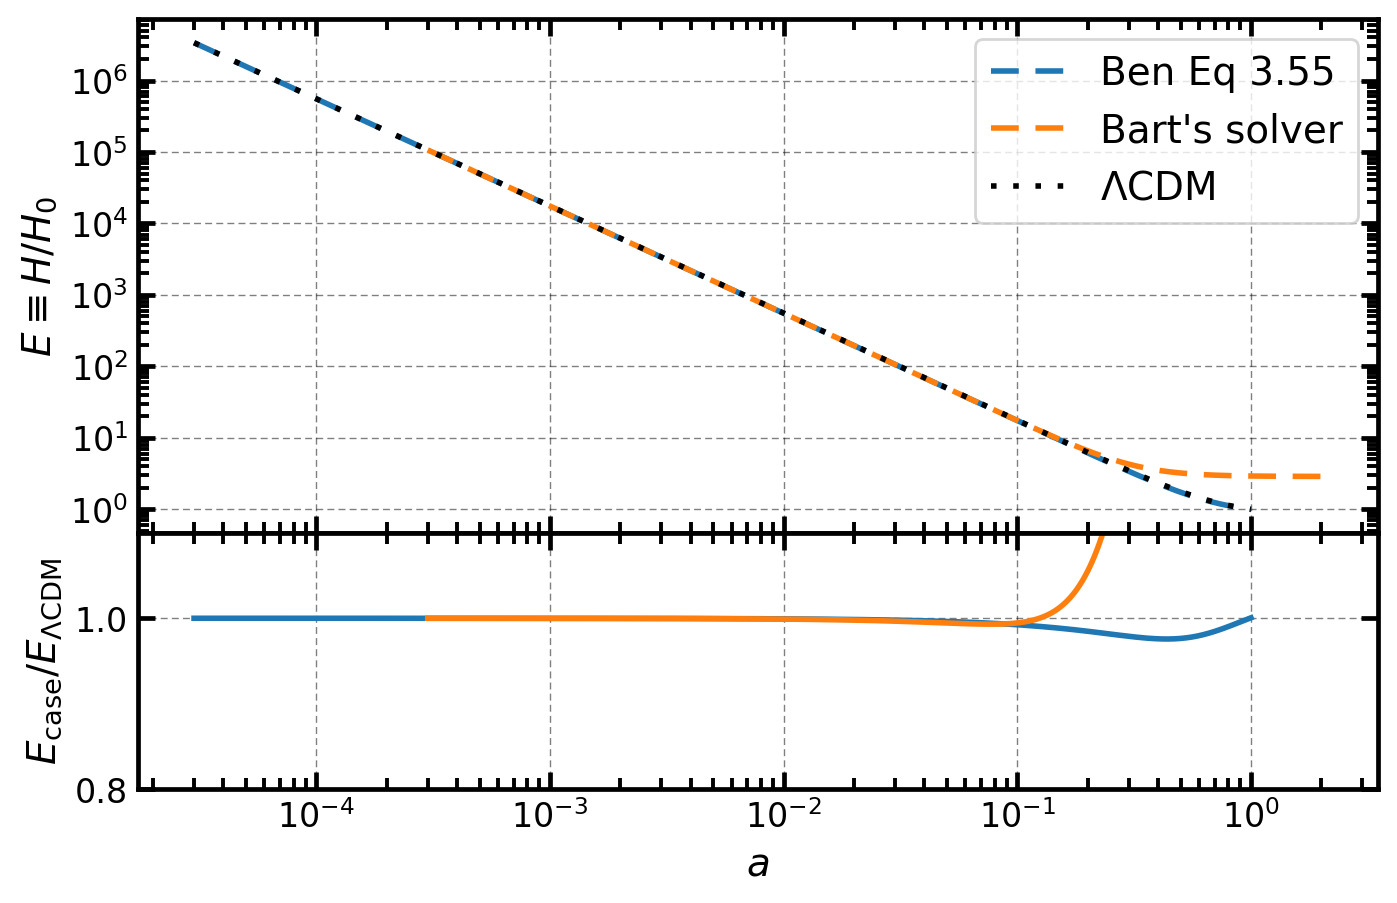

In [192]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
# axs[0].plot(H_kmou_sol['t'], E_3p55, label='Bart Eq 3.55')
axs[0].plot(df_Ben_BG.index, df_Ben_BG['H_MG'], '--', label='Ben Eq 3.55' )
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), '--',label="Bart's solver")
axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E \equiv H/H_0$')

#axs[1].plot(H_kmou_sol['t'], E_3p55/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label='Bart Eq 3.55')
axs[1].plot(df_Ben_BG.index, df_Ben_BG['H_MG']/lambdify(a,H_LCDM)(df_Ben_BG.index)*H0_hinvMpc, label='Ben Eq 3.55' )
axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(0.8,1.1)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
fig.subplots_adjust(hspace=0);

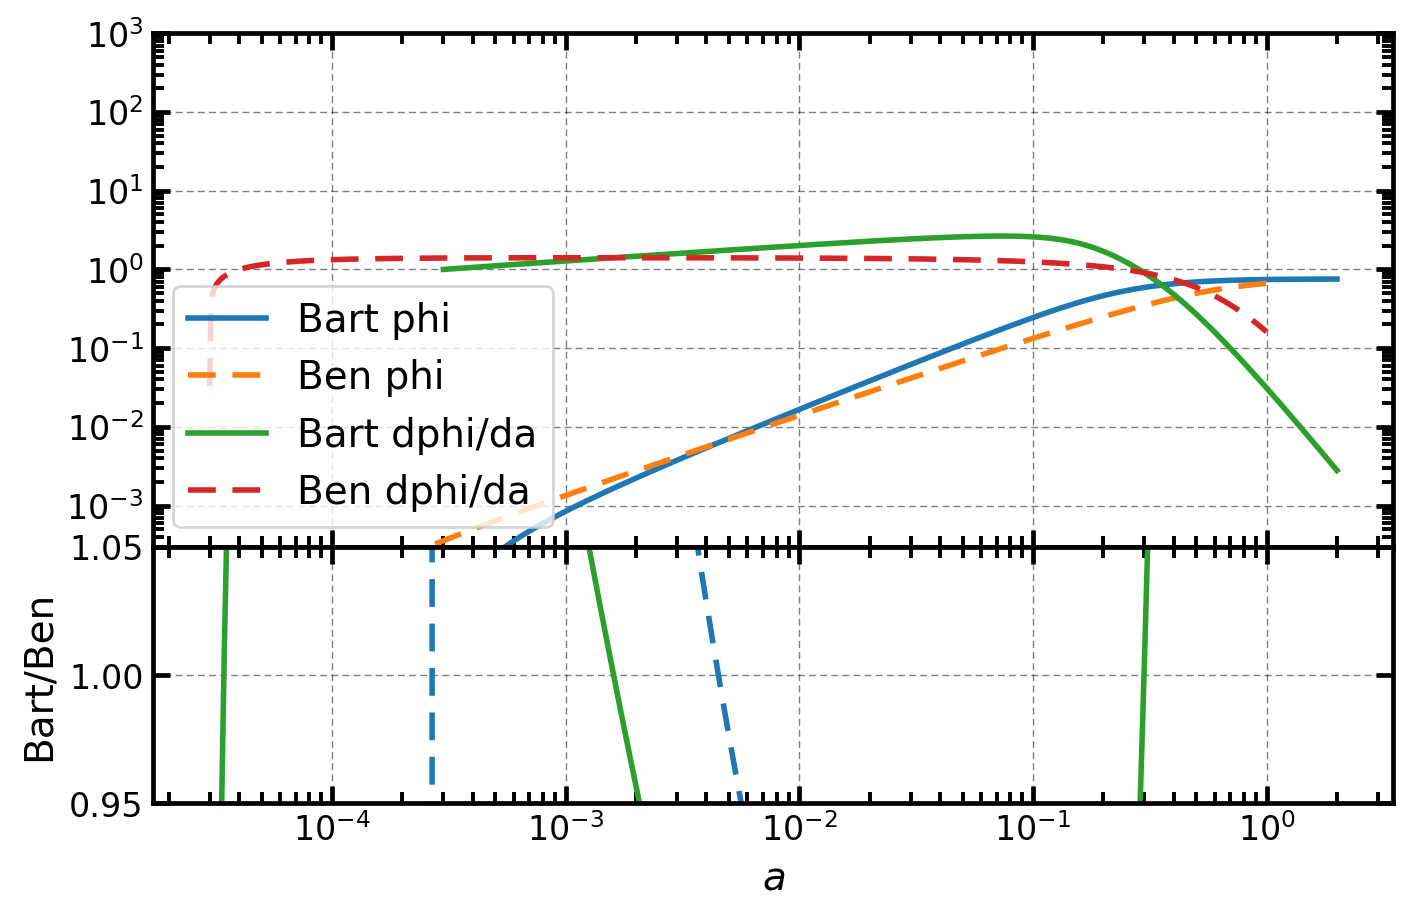

In [193]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][0]), label='Bart phi')
axs[0].plot(df_Ben_BG.index, abs(df_Ben_BG['phi']), '--',label='Ben phi' )
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][1]), label='Bart dphi/da')
axs[0].plot(df_Ben_BG.index, abs(df_Ben_BG['d phi/ dlna']/df_Ben_BG.index), '--',label='Ben dphi/da' )
# axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(a_ini,1000)
# axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot((df_Ben_BG['d phi/ dlna'])/H_kmou_sol.sol(df_Ben_BG.index)[1]/df_Ben_BG.index, 'C2')
axs[1].plot((df_Ben_BG['phi'])/H_kmou_sol.sol(df_Ben_BG.index)[0], '--C0' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(0.95,1.05)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'Bart/Ben')
fig.subplots_adjust(hspace=0);

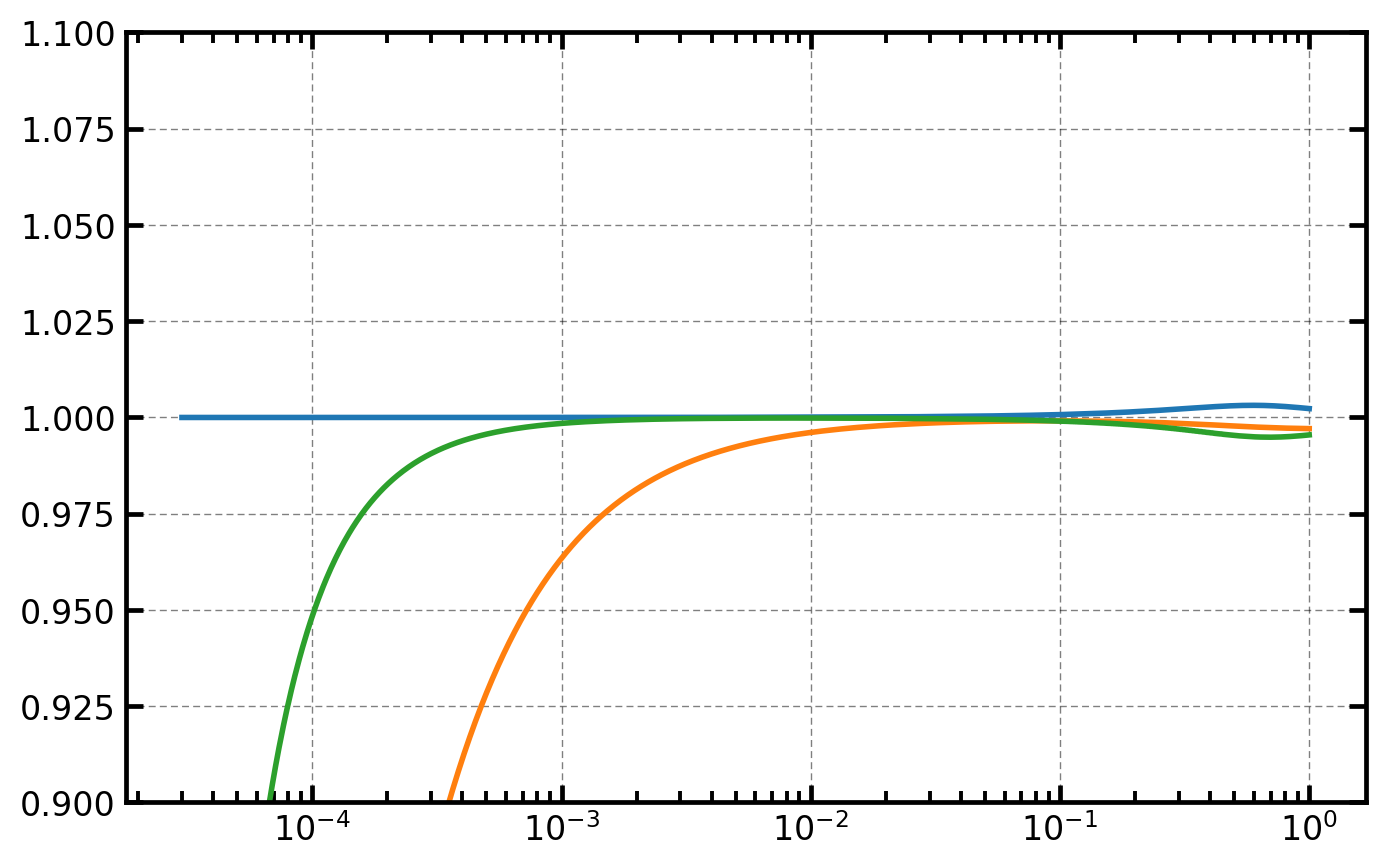

In [30]:
# plt.loglog(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]))
plt.semilogx(abs(df_Ben_BG['H_MG'])/H_kmou_sol.sol(df_Ben_BG.index)[2])
plt.semilogx((df_Ben_BG['phi'])/H_kmou_sol.sol(df_Ben_BG.index)[0])
plt.semilogx((df_Ben_BG['d phi/ dlna'])/H_kmou_sol.sol(df_Ben_BG.index)[1]/df_Ben_BG.index)
plt.ylim(0.9,1.1)

### Test result
The solver accumulates error on $E$ which then leaks to errors on $\phi$ and $\phi_a$

# Test 2

We now try using only 2 equations by substituting $E(\phi, \phi_a)$ in the other two equations thanks to the first Friedmann equation (3.55 of the MG-GLAM paper)

In [167]:
lamb =3
beta=0.2 
n=3
K0=1
H0_target=1
a_ini=3e-5
a_fin=2

In [168]:
phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
phi = Function(r'\phi')(a)
phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
# symbols for system of diff eq
phi_a = symbols(r'\phi_a')

phi_p = a*H_conf*phi.diff(a)
phi_pp = a*H_conf*(phi_p).diff(a)

A = exp(beta*phi)
rho_m = Om*H0_hinvMpc**2/(8*pi*G/3) # convert rho_m into Om
phi_d = phi_p/a
phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf

K = (-1 + X + K0*X**n)
K_x = K.diff(X)
K_xx = K_x.diff(X)
X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_x_bar = K_x.subs(X, X_bar)
K_xx_bar = K_xx.subs(X, X_bar)

kmou_back = (K_x + 2*X*K_xx)*phi_dd + 3*H*K_x*phi_d + A.diff(phi)*8*pi*G * rho_m
E_kmou_a_eq = ((1/3*(-4*pi*G*A*rho_m - K_x*phi_d**2 - 2*lamb**2*H0_hinvMpc**2*K) - H**2)/H_conf/H0_hinvMpc).expand()
H_kmou_sq = 8*pi*G/3*(A*rho_m)+(1/3*K_x*phi_d**2 - 1/3*lamb**2*K*H0_hinvMpc**2) -H**2

phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
phi = Function(r'\phi')(a)
phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
# symbols for system of diff eq
phi_a = symbols(r'\phi_a')

phi_p = a*H_conf*phi.diff(a)
phi_pp = a*H_conf*(phi_p).diff(a)

A = exp(beta*phi)
rho_m = Om*H0_hinvMpc**2/(8*pi*G/3) # convert rho_m into Om
phi_d = phi_p/a
phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf

K = (-1 + X + K0*X**n)
K_x = K.diff(X)
K_xx = K_x.diff(X)
X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_x_bar = K_x.subs(X, X_bar)
K_xx_bar = K_xx.subs(X, X_bar)

kmou_back = (K_x + 2*X*K_xx)*phi_dd + 3*H*K_x*phi_d + A.diff(phi)*8*pi*G * rho_m
E_kmou_a_eq = ((1/3*(-4*pi*G*A*rho_m - K_x*phi_d**2 - 2*lamb**2*H0_hinvMpc**2*K) - H**2)/H_conf/H0_hinvMpc).expand()
H_kmou_sq = 8*pi*G/3*(A*rho_m)+(1/3*K_x*phi_d**2 - 1/3*lamb**2*K*H0_hinvMpc**2) -H**2
E_kmou = solve(H_kmou_sq.subs(X, X_bar), E)[1].subs(phi.diff(a),phi_a)
E_kmou_a_eq = E_kmou_a_eq.subs(X, X_bar).subs(phi.diff(a),phi_a).subs(E, E_kmou)
# H_LCDM = H0_hinvMpc*sqrt(Om+Ol)
# E_kmou_a_eq = (H_LCDM/H0_hinvMpc).diff(a)

In [169]:
dphia_o_da_sym_eq = solve(kmou_back.subs(phi.diff(a),phi_a),Derivative(phi_a,a))[0]
dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(X, X_bar).subs(E.diff(a), E_kmou_a_eq).subs(E, E_kmou).subs(phi.diff(a),phi_a)


dphi_o_da_eq = lambdify((a, phi, phi_a), phi_a)
dphia_o_da_eq = lambdify((a, phi, phi_a), dphia_o_da_sym_eq)

def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (dphi_o_da_eq(t,vec[0],vec[1]),
            dphia_o_da_eq(t,vec[0],vec[1]))

# Compute the solution of the differential equation
H_kmou_sol = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-1.4*a_ini, -1.4), dense_output=True, rtol=1e-13,
#                   method='Radau'
                      )

<lambdifygenerated-85>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.0878410461157882*(-20.2442877068526*Dummy_4472**5*(-1.79949224060912*Dummy_4472**6*(-a**2*(sqrt(0.16087962962963/Dummy_4472**12 + 0.0321770833333333*exp(0.2*_Dummy_4471)/(Dummy_4472**12*a**3) + 0.00165658350694444*exp(0.4*_Dummy_4471)/(Dummy_4472**12*a**6) - 0.0833333333333333/(Dummy_4472**14*a**2) + 0.5/(Dummy_4472**16*a**4) - 1/(Dummy_4472**18*a**6)) + 0.395284707521047/Dummy_4472**6 + 0.0407011487177505*exp(0.2*_Dummy_4471)/(Dummy_4472**6*a**3))**(-0.666666666666667)*sqrt(0.16087962962963/Dummy_4472**12 + 0.0321770833333333*exp(0.2*_Dummy_4471)/(Dummy_4472**12*a**3) + 0.00165658350694444*exp(0.4*_Dummy_4471)/(Dummy_4472**12*a**6) - 0.0833333333333333/(Dummy_4472**14*a**2) + 0.5/(Dummy_4472**16*a**4) - 1/(Dummy_4472**18*a**6)) + 0.166666666666667*a**2*(sqrt(0.16087962962963/Dummy_4472**12 + 0.0321770833333333*exp(0.2*_Dummy_4471)/(Dummy_4472**12*a**3) + 0.00165658350694444*exp(0.4*_Dummy_4471)/(Dum

KeyboardInterrupt: 

In [34]:
H_kmou_sq = 8*pi*G/3*(A*rho_m)+(1/3*K_x*phi_d**2 - 1/3*lamb**2*K*H0_hinvMpc**2) -H**2

E_kmou_sqrt = solve(H_kmou_sq.subs(X, X_bar), E)[1]

E_3p55 = np.array([lambdify((a, phi, phi_a), E_kmou_sqrt.subs(Derivative(phi, a), phi_a))(t,f,f_p) 
                   for t,f,f_p in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1])])

E_3p55_Ben = np.array([lambdify((a, phi, phi_a), E_kmou_sqrt.subs(Derivative(phi, a), phi_a))(t,f,f_p) for 
                   t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

<>:5: SyntaxWarning: invalid escape sequence '\L'
<>:5: SyntaxWarning: invalid escape sequence '\L'
/var/folders/_0/rw1qxx2x3ss_l_mx90qfbv740000gn/T/ipykernel_73999/2444229911.py:5: SyntaxWarning: invalid escape sequence '\L'
  axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k--', label='$\Lambda$CDM')


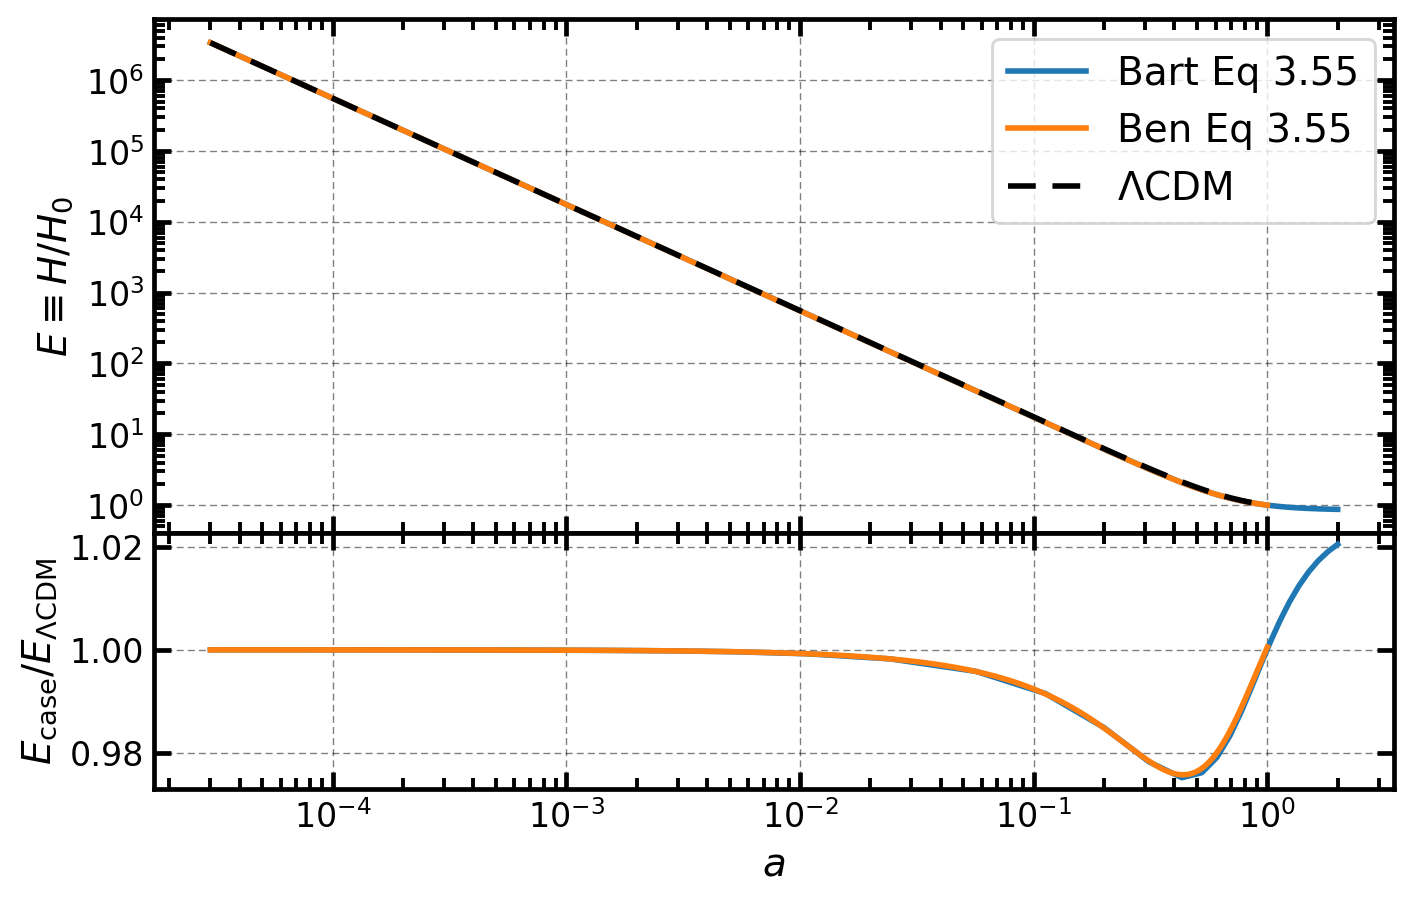

In [35]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], E_3p55, label='Bart Eq 3.55')
axs[0].plot(df_Ben_BG.index, E_3p55_Ben, label='Ben Eq 3.55' )
# axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")
axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k--', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot(H_kmou_sol['t'], E_3p55/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label='Bart Eq 3.55')
axs[1].plot(df_Ben_BG.index, E_3p55_Ben/lambdify(a,H_LCDM)(df_Ben_BG.index)*H0_hinvMpc, label='Ben Eq 3.55' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
# axs[1].set_ylim(0.8,1.1)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
fig.subplots_adjust(hspace=0);

# Test 3

We now try using $N\equiv \log{a}$ as time variable.

In [36]:
#Symbolic variables
N= symbols('N')

lamb =1.476
beta=0.2 
n=2
K0=1
H0_target=1
a_ini=3e-5
a_fin=2

In [37]:
phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
phi = Function(r'\phi')(N)
E_N = Function(r'E')(N)
phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
# symbols for system of diff eq
phi_N = symbols(r'\phi_N')

H_N = H0_hinvMpc*E_N
H_conf_N = H_N*exp(N)
# Om = Om0*a**(-3)
# Ol = Ol0

phi_p = H_conf_N*phi.diff(N)
phi_pp = H_conf_N*(phi_p).diff(N)

A = exp(beta*phi)
rho_m = Om*H0_hinvMpc**2/(8*pi*G/3) # convert rho_m into Om
phi_d = phi_p/a
phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf_N

K = (-1 + X + K0*X**n)
K_x = K.diff(X)
K_xx = K_x.diff(X)
X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2).subs(a, exp(N))
K_x_bar = K_x.subs(X, X_bar)
K_xx_bar = K_xx.subs(X, X_bar)

kmou_back = ((K_x + 2*X*K_xx)*phi_dd + 3*H_N*K_x*phi_d + A.diff(phi)*8*pi*G * rho_m).subs(a, exp(N))
E_kmou_N_eq = (a*((1/3*(-4*pi*G*A*rho_m - K_x*phi_d**2/2 - lamb**2*H0_hinvMpc**2*K) - H_N**2)/H_conf_N/H0_hinvMpc).expand())
H_kmou_sq = (8*pi*G/3*(A*rho_m)+(1/3*K_x*phi_d**2 - 1/3*lamb**2*K*H0_hinvMpc**2) -H_N**2)

E_kmou = solve(H_kmou_sq.subs(X, X_bar), E_N)[1].subs(phi.diff(N),phi_N).subs(a,exp(N))
E_kmou_N_eq = E_kmou_N_eq.subs(X, X_bar).subs(phi.diff(N),phi_N).subs(E_N, E_kmou)

dphia_o_dN_sym_eq = solve(kmou_back.subs(phi.diff(N),phi_N),Derivative(phi_N,N))[0]

dphia_o_dN_sym_eq = dphia_o_dN_sym_eq.subs(X, X_bar).subs(E_N.diff(N), E_kmou_N_eq).subs(a,exp(N)).subs(E_N, E_kmou).subs(phi.diff(N),phi_N)

dphi_o_dN_eq = lambdify((N, phi, phi_N), phi_N)
dphia_o_dN_eq = lambdify((N, phi, phi_N), dphia_o_dN_sym_eq.expand())

def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (dphi_o_dN_eq(t,vec[0],vec[1]),
            dphia_o_dN_eq(t,vec[0],vec[1]))

# Compute the solution of the differential equation
H_kmou_sol = solve_ivp(dum_fun, t_span=(np.log(a_ini),0), y0=(-a_ini, -1*a_ini), dense_output=True, 
                       rtol=1e-9,
                       atol=1e-9
#                   method='Radau'
                      )

In [38]:
E_3p55 = np.array([lambdify((N, phi, phi_N), E_kmou.subs(Derivative(phi, N), phi_N))(t,f,f_p) 
                   for t,f,f_p in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1])])

# E_3p55_Ben = np.array([lambdify((a, phi, phi_a), E_kmou_sqrt.subs(Derivative(phi, a), phi_a))(t,f,f_p) for 
#                    t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

<>:5: SyntaxWarning: invalid escape sequence '\L'
<>:5: SyntaxWarning: invalid escape sequence '\L'
/var/folders/_0/rw1qxx2x3ss_l_mx90qfbv740000gn/T/ipykernel_73999/3379494958.py:5: SyntaxWarning: invalid escape sequence '\L'
  axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')


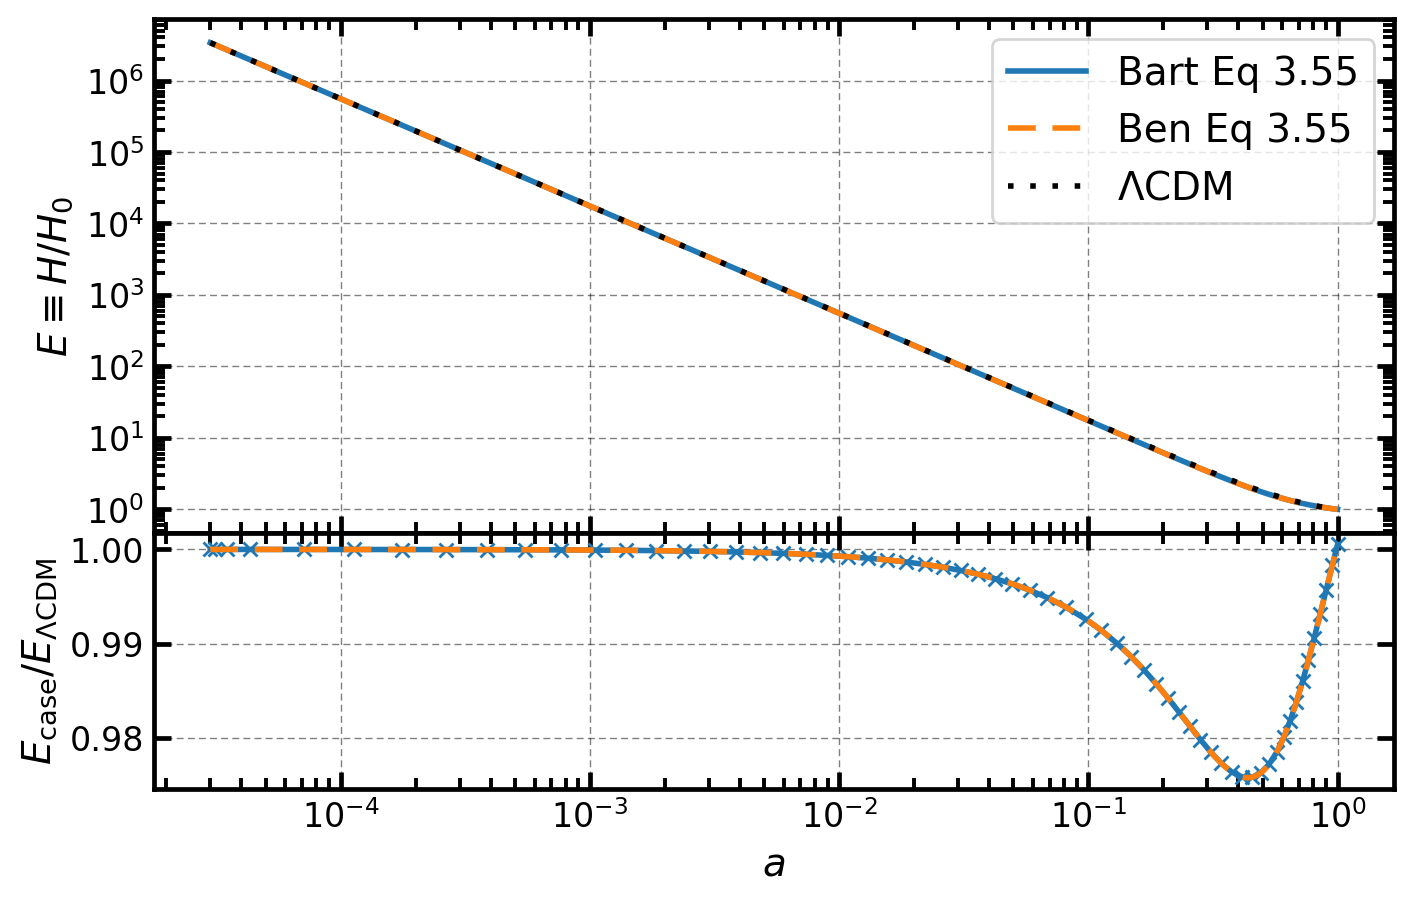

In [39]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(np.exp(H_kmou_sol['t']), E_3p55, label='Bart Eq 3.55')
axs[0].plot(df_Ben_BG.index, E_3p55_Ben, '--',label='Ben Eq 3.55' )
# axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")
axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot(np.exp(H_kmou_sol['t']), E_3p55/lambdify(a,H_LCDM)(np.exp(H_kmou_sol['t']))*H0_hinvMpc, 'x-',label='Bart Eq 3.55')
axs[1].plot(df_Ben_BG.index, E_3p55_Ben/lambdify(a,H_LCDM)(df_Ben_BG.index)*H0_hinvMpc, '--',label='Ben Eq 3.55' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
# axs[1].set_ylim(0.8,1.1)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
fig.subplots_adjust(hspace=0);

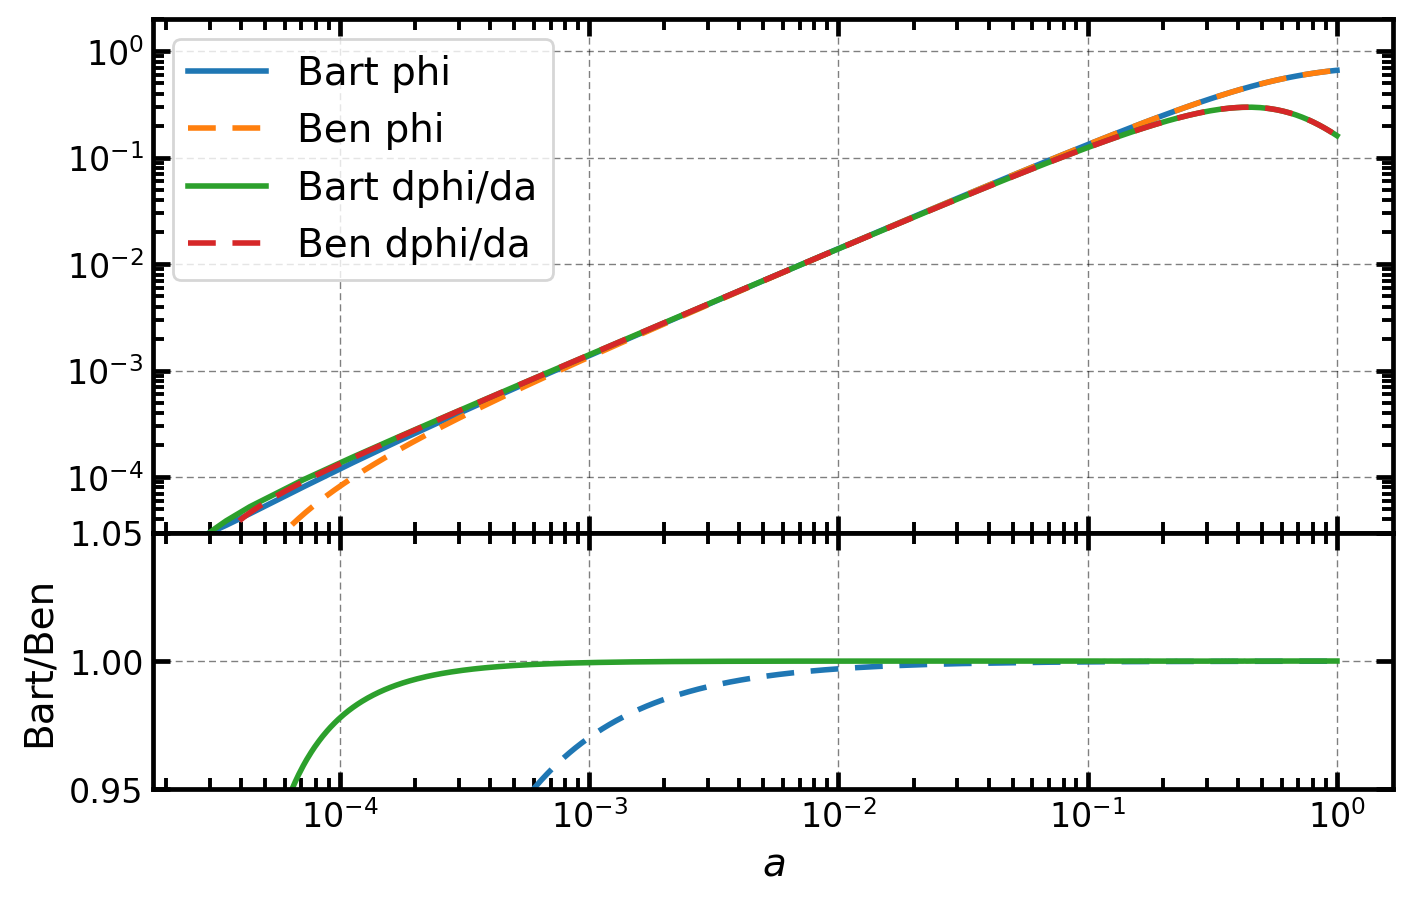

In [40]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(np.exp(H_kmou_sol['t']), abs(H_kmou_sol['y'][0]), label='Bart phi')
axs[0].plot(df_Ben_BG.index, abs(df_Ben_BG['phi']), '--',label='Ben phi' )
axs[0].plot(np.exp(H_kmou_sol['t']), abs(H_kmou_sol['y'][1]), label='Bart dphi/da')
axs[0].plot(df_Ben_BG.index, abs(df_Ben_BG['d phi/ dlna']), '--',label='Ben dphi/da' )
# axs[0].plot(np.exp(H_kmou_sol['t']), abs(H_kmou_sol['y'][2]), label="Bart's solver")

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(a_ini,2)
# axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot((df_Ben_BG['phi'])/H_kmou_sol.sol(np.log(df_Ben_BG.index))[0], '--C0' )
axs[1].plot((df_Ben_BG['d phi/ dlna'])/H_kmou_sol.sol(np.log(df_Ben_BG.index))[1], 'C2')
# axs[1].plot(np.exp(H_kmou_sol['t']), abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(np.exp(H_kmou_sol['t']))*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(0.95,1.05)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'Bart/Ben')
fig.subplots_adjust(hspace=0);

# Test 4

We now try using only the Friedmann equations

In [37]:
# lamb =1.476
lamb_val = nsimplify(1.476)
lamb =symbols(r'\lambda')
beta=0.2 
n=2 
K0=1
H0_target=1
a_ini=1e-5
a_fin=2

In [38]:
# test increasing precision
import mpmath as mp
mp.dps = 15
mp.prec = 53

In [39]:
phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
phi = Function(r'\phi')(a)
phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
# symbols for system of diff eq
phi_a = symbols(r'\phi_a')

phi_p = a*H_conf*phi.diff(a)
phi_pp = a*H_conf*(phi_p).diff(a)

A = exp(beta*phi)
rho_m = (Om*H0_hinvMpc**2/(8*pi*G/3))#.evalf(30) # convert rho_m into Om
phi_d = phi_p/a
phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf

K = (-1 + X + K0*X**n)
K_x = K.diff(X)
K_xx = K_x.diff(X)
X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_x_bar = K_x.subs(X, X_bar)
K_xx_bar = K_xx.subs(X, X_bar)

kmou_back = ((K_x + 2*X*K_xx)*phi_dd + 3*H*K_x*phi_d + A.diff(phi)*8*pi*G * rho_m).evalf(n=30, subs={Om0:Om0_val})
H_kmou_sq = rho_m/3*8*pi*G*A+(K_x*phi_d**2/3 - lamb**2*K*H0_hinvMpc**2/3) -H**2
# E_kmou = solve(H_kmou_sq.subs(X, X_bar), E)[1]#.subs(phi.diff(a),phi_a)
E_kmou = solve(H_kmou_sq.subs(X, X_bar), E)[1]#/N(sqrt(2)))*sqrt(2)

In [40]:
# ---------------------------- READ ----------------------------
# The chosen equation to compute the derivative E' has an effect on the solution
E_kmou_a_eq = (((-4*pi*G*A*rho_m - K_x*phi_d**2/2 - lamb**2*H0_hinvMpc**2*K)/3-H**2)/H_conf/H0_hinvMpc).evalf(n=30, subs={Om0:Om0_val})
# E_kmou_a_eq = E_kmou.diff(a)#
# E_kmou_a_eq = E_kmou_a_eq.subs(E, E_kmou)
# H_LCDM = H0_hinvMpc*sqrt(Om+Ol)
# E_kmou_a_eq = (H_LCDM/H0_hinvMpc).diff(a)

In [41]:
# kmou_back = kmou_back.subs(X, X_bar)
# E_kmou_a_eq = E_kmou_a_eq.subs(X, X_bar).expand()

dphia_o_da_sym_eq = solve(kmou_back.subs(phi.diff(a),phi_a),Derivative(phi_a,a))[0]
# ---------------------------- READ ----------------------------
# Substuting E_kmou inside dphia_o_da_sym_eq produces a different results than using the integrated E
# dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E.diff(a), E_kmou_a_eq).subs(X, X_bar).subs(E, E_kmou).subs(phi.diff(a),phi_a)
dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E.diff(a), E_kmou_a_eq).subs(X, X_bar).subs(phi.diff(a),phi_a)

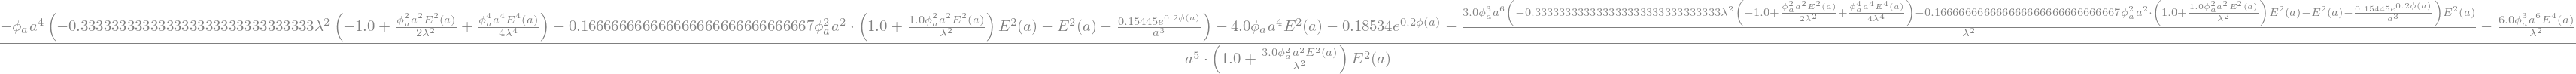

In [42]:
dphia_o_da_sym_eq

In [47]:
# dphia_o_da_sym_eq = solve(kmou_back.subs(E.diff(a),E_kmou_a_eq).subs(phi.diff(a),phi_a), Derivative(phi_a,a))[0]
dE_o_da_sym_eq = E_kmou_a_eq.subs(X, X_bar).subs(phi.diff(a),phi_a).subs(lamb,lamb_val)

In [112]:
phi_a_eq = solve(E_kmou.subs(phi.diff(a), phi_a) - E**2, phi_a)[3]

In [ ]:
dum_sol = solve(E_kmou.subs(phi.diff(a), phi_a) - E**2, phi_a)

In [ ]:
dum_sol[2]

In [ ]:
dum_sol[1]

In [113]:
dphi_o_da_eq = lambdify((a, phi, E), phi_a_eq.subs(lamb, lamb_val))
# dphia_o_da_eq = lambdify((a, phi, phi_a, E), dphia_o_da_sym_eq.evalf(30, subs={lamb:lamb_val}),
#                         modules='mpmath')
dE_o_da_eq = lambdify((a, phi, E), dE_o_da_sym_eq.subs(phi_a, phi_a_eq).evalf(30, subs={lamb:lamb_val}),
                     modules='mpmath')

In [114]:
def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (dphi_o_da_eq(t,vec[0], vec[1]),
           dE_o_da_eq(t,vec[0], vec[1]))

# Compute the solution of the differential equation
H_kmou_sol = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-0.1*a_ini, H_LCDM.subs(a,a_ini)/H0_hinvMpc),
                       dense_output=True, rtol=1e-9,
                       # method='LSODA',
                       atol=1e-9
                      )

<lambdifygenerated-2732>:2: RuntimeWarning: invalid value encountered in sqrt
  return -0.00489897948556637*sqrt(410)*sqrt(-(73.8*a**2 + 299.999999999999*sqrt(_Dummy_7278**4*a**4 - 0.665676000000005*a**4 - 0.308900000000002*a*exp(0.2*_Dummy_7277)))/_Dummy_7278**4)/a**2


KeyboardInterrupt: 

In [ ]:
H_kmou_sq = 8*pi*G/3*(A*rho_m)+(1/3*K_x*phi_d**2 - 1/3*lamb**2*K*H0_hinvMpc**2) -H**2

E_kmou_sqrt = solve(H_kmou_sq.subs(X, X_bar).evalf(n=15, subs={Om0:Om0_val, lamb:lamb_val}), E)[1]

E_3p55 = np.array([lambdify((a, phi, phi_a), E_kmou_sqrt.subs(Derivative(phi, a), phi_a))(t,f,f_p) 
                   for t,f,f_p in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1])])

E_3p55_Ben = np.array([lambdify((a, phi, phi_a), E_kmou_sqrt.subs(Derivative(phi, a), phi_a))(t,f,f_p) for 
                   t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

In [ ]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
# axs[0].plot(H_kmou_sol['t'], E_3p55, label='Bart Eq 3.55')
axs[0].plot(df_Ben_BG.index, E_3p55_Ben, '--', label='Ben Eq 3.55' )
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), '--',label="Bart's solver")
axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E \equiv H/H_0$')

#axs[1].plot(H_kmou_sol['t'], E_3p55/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label='Bart Eq 3.55')
axs[1].plot(df_Ben_BG.index, E_3p55_Ben/lambdify(a,H_LCDM)(df_Ben_BG.index)*H0_hinvMpc, label='Ben Eq 3.55' )
axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(0.8,1.1)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
fig.subplots_adjust(hspace=0);

In [ ]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][0]), label='Bart phi')
axs[0].plot(df_Ben_BG.index, abs(df_Ben_BG['phi']), '--',label='Ben phi' )
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][1]), label='Bart dphi/da')
axs[0].plot(df_Ben_BG.index, abs(df_Ben_BG['d phi/ dlna']/df_Ben_BG.index), '--',label='Ben dphi/da' )
# axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(a_ini,1000)
# axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot((df_Ben_BG['d phi/ dlna'])/H_kmou_sol.sol(df_Ben_BG.index)[1]/df_Ben_BG.index, 'C2')
axs[1].plot((df_Ben_BG['phi'])/H_kmou_sol.sol(df_Ben_BG.index)[0], '--C0' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(0.95,1.05)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'Bart/Ben')
fig.subplots_adjust(hspace=0);

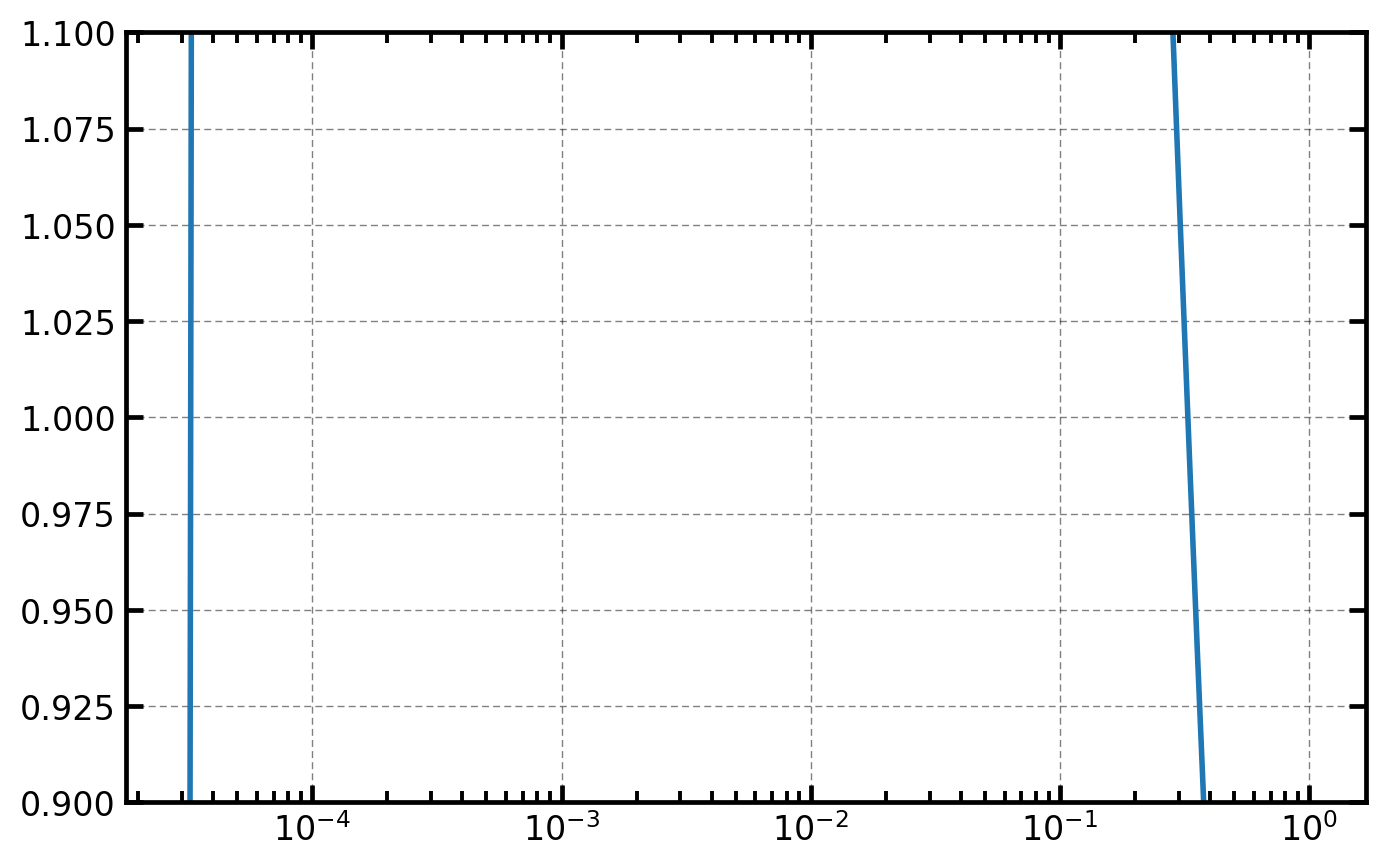

In [106]:
# plt.loglog(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]))
# plt.semilogx(abs(df_Ben_BG['H_MG'])/H_kmou_sol.sol(df_Ben_BG.index)[2])
plt.semilogx((df_Ben_BG['phi'])/H_kmou_sol.sol(df_Ben_BG.index)[0])
plt.semilogx((df_Ben_BG['d phi/ dlna'])/H_kmou_sol.sol(df_Ben_BG.index)[1]/df_Ben_BG.index)
plt.ylim(0.9,1.1)

# Export solver

In [164]:
def solve_Kmou_expansion(lamb=1, beta=0.2, n=2, K0=1, mode='search', H0_target=1, a_ini=3e-5, a_fin=1):
    phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
    phi = Function(r'\phi')(a)
    phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
    # symbols for system of diff eq
    phi_a = symbols(r'\phi_a')

    phi_p = a*H_conf*phi.diff(a)
    phi_pp = a*H_conf*(phi_p).diff(a)

    A = exp(beta*phi)
    rho_m = Om*H0_hinvMpc**2/(8*pi*G/3) # convert rho_m into Om
    phi_d = phi_p/a
    phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf

    K = (-1 + X + K0*X**n)
    K_x = K.diff(X)
    K_xx = K_x.diff(X)
    X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
    K_x_bar = K_x.subs(X, X_bar)
    K_xx_bar = K_xx.subs(X, X_bar)

    kmou_back = (K_x + 2*X*K_xx)*phi_dd + 3*H*K_x*phi_d + A.diff(phi)*8*pi*G * rho_m
    E_kmou_a_eq = ((1/3*(-4*pi*G*A*rho_m - K_x*phi_d**2 - 2*lamb**2*H0_hinvMpc**2*K) - H**2)/H_conf/H0_hinvMpc).expand()
    H_kmou_sq = 8*pi*G/3*(A*rho_m)+(1/3*K_x*phi_d**2 - 1/3*lamb**2*K*H0_hinvMpc**2) -H**2

    phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
    phi = Function(r'\phi')(a)
    phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
    # symbols for system of diff eq
    phi_a = symbols(r'\phi_a')

    phi_p = a*H_conf*phi.diff(a)
    phi_pp = a*H_conf*(phi_p).diff(a)

    A = exp(beta*phi)
    rho_m = Om*H0_hinvMpc**2/(8*pi*G/3) # convert rho_m into Om
    phi_d = phi_p/a
    phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf

    K = (-1 + X + K0*X**n)
    K_x = K.diff(X)
    K_xx = K_x.diff(X)
    X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
    K_x_bar = K_x.subs(X, X_bar)
    K_xx_bar = K_xx.subs(X, X_bar)

    kmou_back = (K_x + 2*X*K_xx)*phi_dd + 3*H*K_x*phi_d + A.diff(phi)*8*pi*G * rho_m
    E_kmou_a_eq = ((1/3*(-4*pi*G*A*rho_m - K_x*phi_d**2/2 - lamb**2*H0_hinvMpc**2*K) - H**2)/H_conf/H0_hinvMpc).expand()
    H_kmou_sq = 8*pi*G/3*(A*rho_m)+(1/3*K_x*phi_d**2 - 1/3*lamb**2*K*H0_hinvMpc**2) -H**2
    E_kmou = solve(H_kmou_sq.subs(X, X_bar), E)[1].subs(phi.diff(a),phi_a)
    # E_kmou_a_eq = E_kmou.diff(a)#
    E_kmou_a_eq = E_kmou_a_eq.subs(E, E_kmou)
    # H_LCDM = H0_hinvMpc*sqrt(Om+Ol)
    # E_kmou_a_eq = (H_LCDM/H0_hinvMpc).diff(a)

    kmou_back = kmou_back.subs(X, X_bar).subs(E.diff(a), E_kmou_a_eq).subs(E, E_kmou).subs(X, X_bar).expand().subs(phi.diff(a),phi_a)

    dphia_o_da_sym_eq = solve(kmou_back, Derivative(phi_a,a))[0].subs(E, E_kmou)

    dphi_o_da_eq = lambdify((a, phi, phi_a), phi_a)
    dphia_o_da_eq = lambdify((a, phi, phi_a), dphia_o_da_sym_eq)

    def dum_fun(t,vec):
        '''Dummy function to adapt the input of solve_ivp'''
        return (dphi_o_da_eq(t,vec[0],vec[1]),
                dphia_o_da_eq(t,vec[0],vec[1]))

    # Compute the solution of the differential equation
    H_kmou_sol = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-1*a_ini*1e-15, -1), dense_output=True, 
                           rtol=1e-9,atol=1e-9,
                      method='LSODA'
                          )
    if mode=='search':
        E_kmou_fun =lambdify((a, phi, phi_a), E_kmou)
        return np.array(E_kmou_fun(1, H_kmou_sol.sol(1)[0], H_kmou_sol.sol(1)[1]) - H0_target)/H0_target
    elif mode=='phi':
        return H_kmou_sol
    elif mode=='full':
        E_kmou_fun =lambdify((a, phi, phi_a), E_kmou)
        E_kmou_a_fun =lambdify((a, phi, phi_a), E_kmou_a_eq.subs(X, X_bar).subs(phi.diff(a),phi_a).subs(E,E_kmou))
        return H_kmou_sol, E_kmou_fun, E_kmou_a_fun

In [165]:
from scipy.optimize import newton

In [46]:
a_ini=3e-5
best_lamb = newton(lambda l: solve_Kmou_expansion(l, a_ini=a_ini, beta=0.2, K0=1, n=2), 1.4,maxiter=5)

In [166]:
H_kmou_sol, E_kmou_fun, E_kmou_a_fun = solve_Kmou_expansion(10, beta=0.2, K0=1, n=3, mode='full', a_ini=3e-5)

KeyboardInterrupt: 

In [48]:
E_3p55 = np.array([E_kmou_fun(t,f,f_p) 
                   for t,f,f_p in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1])])

E_3p55_Ben = np.array([E_kmou_fun(t,f,f_p) for 
                   t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

In [49]:
E_3p56 = np.array([E_kmou_a_fun(t,f,f_p) 
                   for t,f,f_p in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1])])

E_3p56_Ben = np.array([E_kmou_a_fun(t,f,f_p) for 
                   t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

<>:5: SyntaxWarning: invalid escape sequence '\L'
<>:5: SyntaxWarning: invalid escape sequence '\L'
/var/folders/_0/rw1qxx2x3ss_l_mx90qfbv740000gn/T/ipykernel_71136/3072586411.py:5: SyntaxWarning: invalid escape sequence '\L'
  axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k--', label='$\Lambda$CDM')


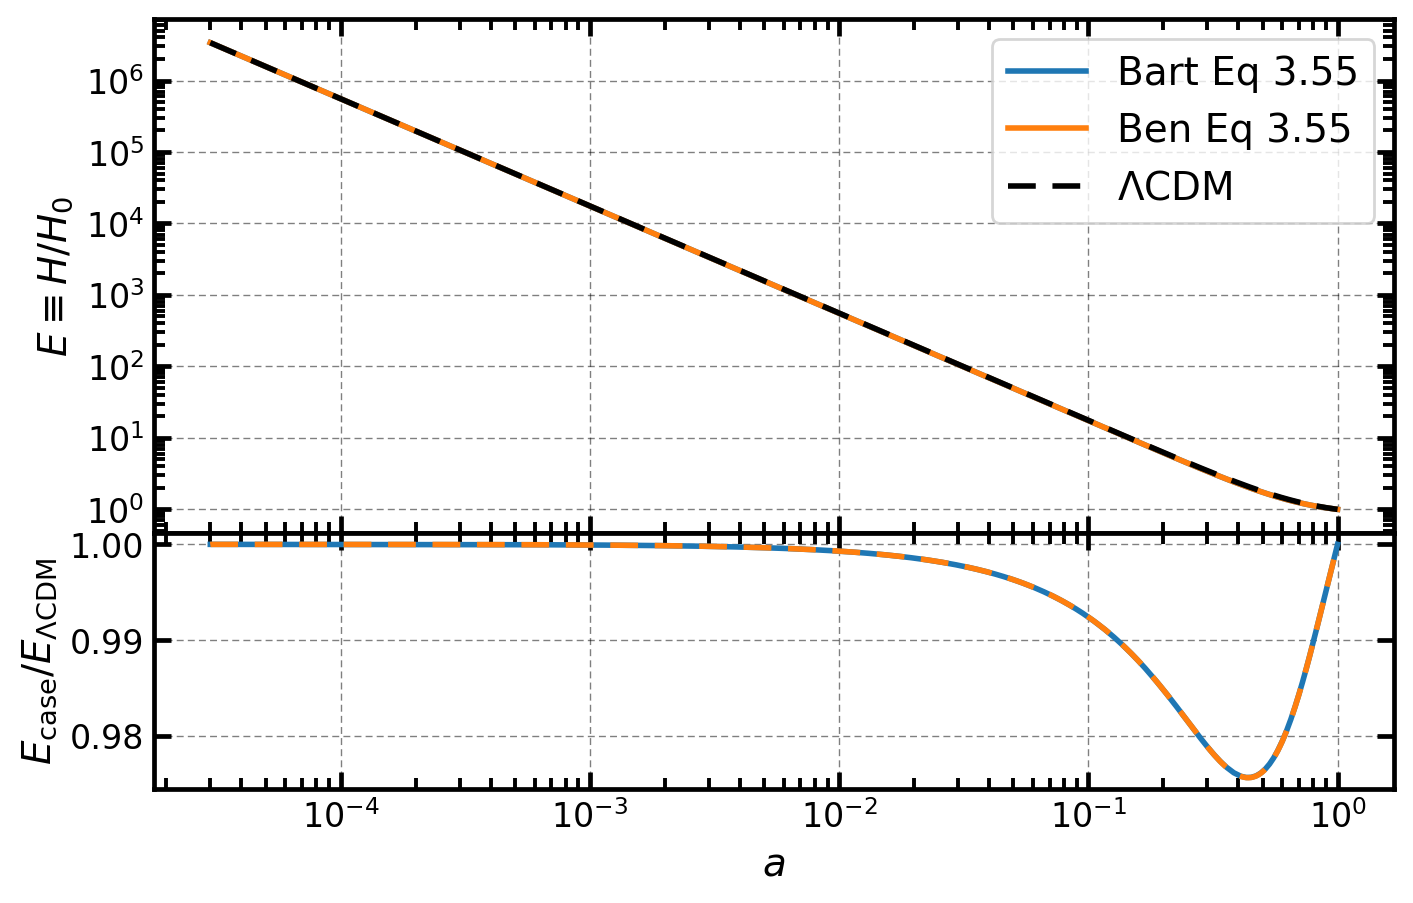

In [50]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], E_3p55, label='Bart Eq 3.55')
axs[0].plot(df_Ben_BG.index, E_3p55_Ben, label='Ben Eq 3.55' )
# axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")
axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k--', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot(H_kmou_sol['t'], E_3p55/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label='Bart Eq 3.55')
axs[1].plot(df_Ben_BG.index, E_3p55_Ben/lambdify(a,H_LCDM)(df_Ben_BG.index)*H0_hinvMpc, '--',label='Ben Eq 3.55' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
# axs[1].set_ylim(0.8,1.1)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
fig.subplots_adjust(hspace=0);

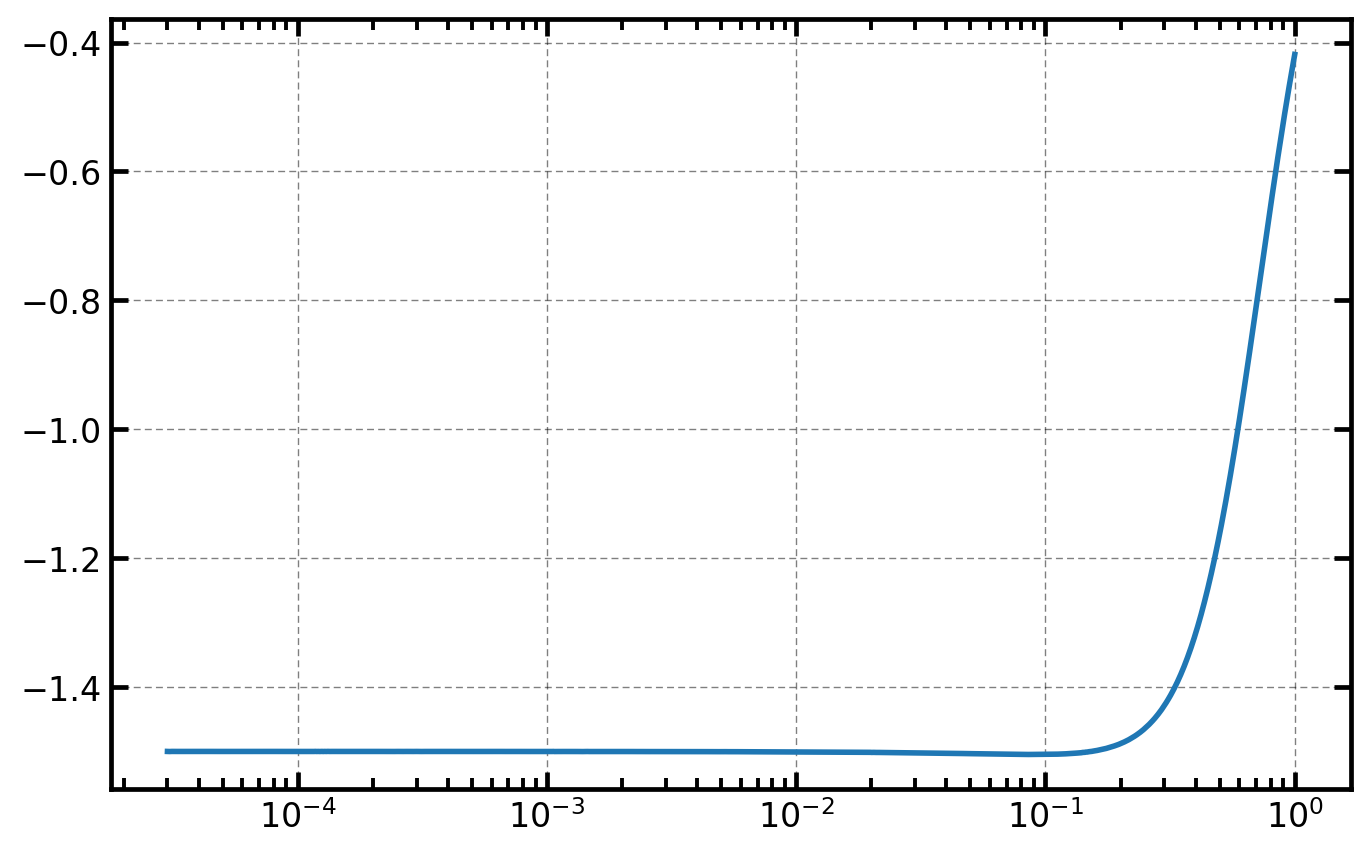

In [51]:
plt.plot(df_Ben_BG.index,df_Ben_BG.index/df_Ben_BG['H_MG']*
         InterpolatedUnivariateSpline(df_Ben_BG.index, df_Ben_BG['H_MG']).derivative()(df_Ben_BG.index))
plt.semilogx()

<>:6: SyntaxWarning: invalid escape sequence '\L'
<>:6: SyntaxWarning: invalid escape sequence '\L'
/var/folders/_0/rw1qxx2x3ss_l_mx90qfbv740000gn/T/ipykernel_71136/3928175129.py:6: SyntaxWarning: invalid escape sequence '\L'
  axs[0].plot(df_Ben_BG.index, lambdify(a,a*H_LCDM.diff(a)/H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')


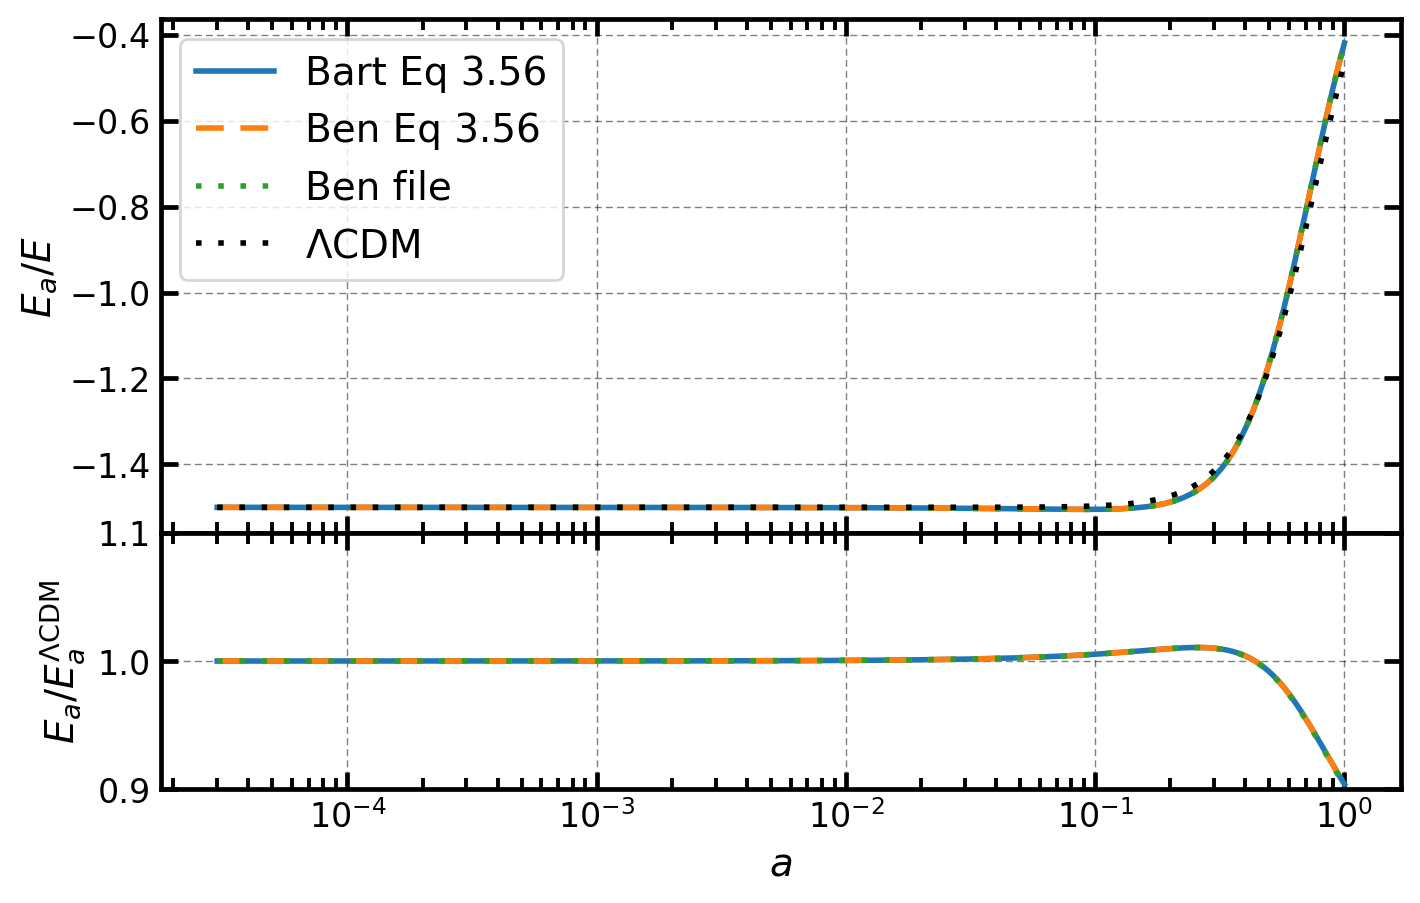

In [52]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], H_kmou_sol['t']*E_3p56/E_3p55, label='Bart Eq 3.56')
axs[0].plot(df_Ben_BG.index, df_Ben_BG.index*E_3p56_Ben/E_3p55_Ben, '--',label='Ben Eq 3.56' )
axs[0].plot(df_Ben_BG.index, (df_Ben_BG['aH dH/da / H0^2']/df_Ben_BG['H_MG']*df_Ben_BG.index), ':',label='Ben file' )
# axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")
axs[0].plot(df_Ben_BG.index, lambdify(a,a*H_LCDM.diff(a)/H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k:', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
# axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E_{a}/E$')

axs[1].plot(H_kmou_sol['t'], (H_kmou_sol['t']*E_3p56/E_3p55)/(lambdify(a,a*H_LCDM.diff(a)/H_LCDM)(H_kmou_sol['t'])/H0_hinvMpc), label='Bart Eq 3.56')
axs[1].plot(df_Ben_BG.index, (df_Ben_BG.index*E_3p56_Ben/E_3p55_Ben)/(lambdify(a,a*H_LCDM.diff(a)/H_LCDM)(df_Ben_BG.index)/H0_hinvMpc), '--',label='Ben Eq 3.56' )
axs[1].plot(df_Ben_BG.index, (df_Ben_BG['aH dH/da / H0^2']/df_Ben_BG['H_MG']*df_Ben_BG.index)/
            (lambdify(a,a*H_LCDM.diff(a)/H_LCDM)(df_Ben_BG.index)/H0_hinvMpc), ':',label='Ben file' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(1-0.1,1+0.1)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{a}/E_{a}^{\rm \Lambda CDM} $')
fig.subplots_adjust(hspace=0);

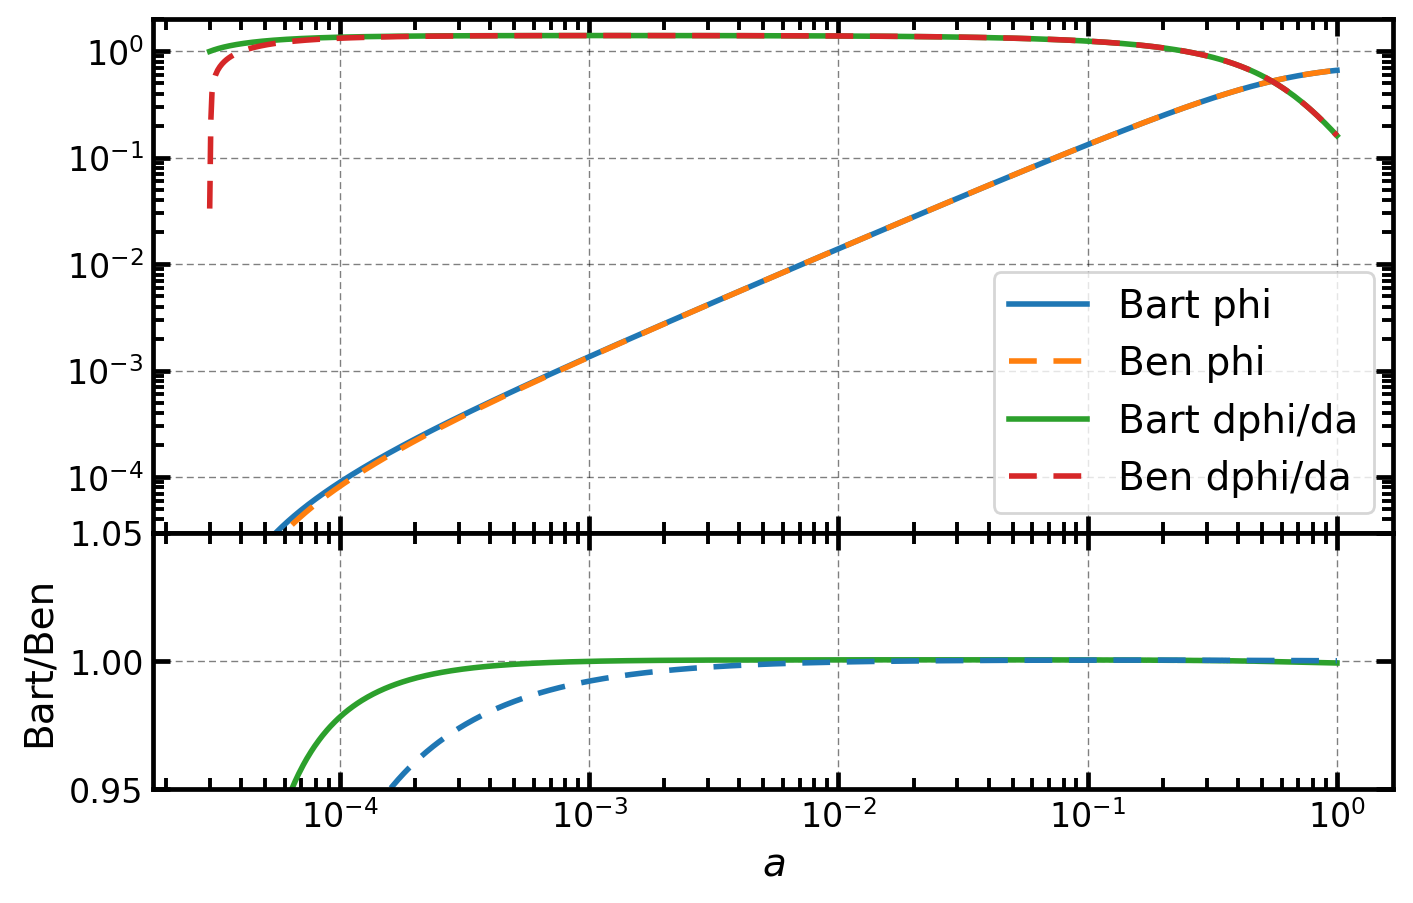

In [53]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][0]), label='Bart phi')
axs[0].plot(df_Ben_BG.index, abs(df_Ben_BG['phi']), '--',label='Ben phi' )
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][1]), label='Bart dphi/da')
axs[0].plot(df_Ben_BG.index, abs(df_Ben_BG['d phi/ dlna']/df_Ben_BG.index), '--',label='Ben dphi/da' )
# axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(a_ini,2)
# axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot((df_Ben_BG['d phi/ dlna'])/H_kmou_sol.sol(df_Ben_BG.index)[1]/df_Ben_BG.index, 'C2')
axs[1].plot((df_Ben_BG['phi'])/H_kmou_sol.sol(df_Ben_BG.index)[0], '--C0' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(0.95,1.05)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'Bart/Ben')
fig.subplots_adjust(hspace=0);

In [54]:
l = 1.4
for i in range(10):
    Delta_E = solve_Kmou_expansion(l, a_ini=3e-4)
    print('Iter ',i, ': Delta_E = ',Delta_E)
    l -= 2*Delta_E

Iter  0 : Delta_E =  -0.03630219960334269
Iter  1 : Delta_E =  -0.0011073756911249566
Iter  2 : Delta_E =  -2.534834450607093e-05
Iter  3 : Delta_E =  -5.747497890951081e-07
Iter  4 : Delta_E =  -1.3070777127310862e-08
Iter  5 : Delta_E =  -2.534951137889152e-10
Iter  6 : Delta_E =  -6.189715406890173e-12
Iter  7 : Delta_E =  4.0783598720395275e-11
Iter  8 : Delta_E =  5.4229065682420696e-11
Iter  9 : Delta_E =  2.8663960094377217e-11


# Jordan frame

We use that:
- $\rho_m = 3 \Omega_m H_0^2 /(8 \pi G)$
- $\frac{d}{dt} = \frac{d}{a d\tau}$
- $\dot{\phi} = \phi^{\prime}/a$
- $\ddot{\phi} = \frac{d}{dt}(\phi^{\prime}/a) = \frac{1}{a^2}\phi^{\prime\prime} - \frac{1}{a^2} \phi^{\prime} \mathcal{H}$

and as above:
$$\frac{d}{d\tau} = a \mathcal{H} \frac{d}{da}$$

In [79]:
lamb =1.476
beta=0.2 
n=3
K0=1
H0_target=1
a_ini=3e-4
a_fin=2

In [80]:
phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
phi = Function(r'\phi')(a)
phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
# symbols for system of diff eq
phi_a = symbols(r'\phi_a')

phi_p = a*H_conf*phi.diff(a)
phi_pp = a*H_conf*(phi_p).diff(a)

A = exp(beta*phi)
rho_m = Om*H0_hinvMpc**2/(8*pi*G/3) # convert rho_m into Om
rho_m0 = Om0_val*H0_hinvMpc**2/(8*pi*G/3) 
phi_d = phi_p/a
phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf

K = (-1 + X + K0*X**n)
K_x = K.diff(X)
K_xx = K_x.diff(X)
X_bar = A**2 * phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_bar = K.subs(X, X_bar)
K_x_bar = K_x.subs(X, X_bar)
K_xx_bar = K_xx.subs(X, X_bar)

In [81]:
M_pl = 1/sqrt(8*pi*G) 
rho_phi = M_pl**2 * H0_hinvMpc**2 *lamb**2 / A**4 * (2*X_bar*K_x_bar - K_bar)
p_phi = M_pl**2 * H0_hinvMpc**2 *lamb**2 / A**4 * (K_bar)
O_phi = rho_phi/(3*H0_hinvMpc**2*M_pl**2)

In [88]:
eps2 = a*beta*phi.diff(a)
eps1 = 2*beta**2/K_x_bar

E_kmou_sq = A**2/(1-eps2)**2 * (Om + O_phi)
# E_kmou = solve(E_kmou_sq - E**2, E)[1]

In [94]:
E_kmou = sqrt(abs(solve(E_kmou_sq.expand()- E**2, E**2)[-1]))

In [95]:
E_kmou_a = - 3/2*H0_hinvMpc/H_conf* (A**2 / (1-eps2) *(Om + (rho_phi + p_phi)/(3*M_pl**2 *H0_hinvMpc**2)) + 
                                    2*A**2/(3*(1-eps2)**2)*(eps2 - 1/(1-eps2)*a*eps2.diff(a))*(Om + O_phi) )

In [96]:
dphia_o_da_sym_eq = H_conf * (A**(-2) * a**3 *H_conf *phi.diff(a)* K_x_bar).diff(a) + beta*rho_m0/M_pl**2

dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E.diff(a), E_kmou_a)
dphia_o_da_sym_eq = solve(dphia_o_da_sym_eq.subs(phi.diff(a), phi_a), Derivative(phi_a, a))[0]
dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E, E_kmou).subs(phi.diff(a), phi_a)

In [97]:
dphi_o_da_eq = lambdify((a, phi, phi_a), phi_a)
dphia_o_da_eq = lambdify((a, phi, phi_a), dphia_o_da_sym_eq)

def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (dphi_o_da_eq(t,vec[0],vec[1]),
            dphia_o_da_eq(t,vec[0],vec[1]))

# Compute the solution of the differential equation
H_kmou_sol = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-1.4*a_ini, -1.4), dense_output=True, 
                       rtol=1e-9,
#                   method='Radau'
                      )

<lambdifygenerated-10>:2: RuntimeWarning: invalid value encountered in sqrt
  return (6.50280068067907e+47*Dummy_1724**13*a**16*exp(7.2*_Dummy_1723)*abs(2.75570488631159*(sqrt(0.15625*(a**3 + 0.425369599224448*exp(0.8*_Dummy_1723))**2*exp(-2.4*_Dummy_1723)/(Dummy_1724**12*a**18) + (0.126666666666667*Dummy_1724**2*a**2 + 0.4*Dummy_1724*a - 1)**3*exp(-2.4*_Dummy_1723)/(Dummy_1724**18*a**18)) + 4.35460272237697e-16*(907740000000000.0*a**3 + 386125000000000.0*exp(0.8*_Dummy_1723))*exp(-1.2*_Dummy_1723)/(Dummy_1724**6*a**9))**(1/3) - 7.34854636349759e-16*(475000000000000.0*Dummy_1724**2*a**2 + 1.5e+15*Dummy_1724*a - 3.75e+15)*exp(-0.8*_Dummy_1723)/(Dummy_1724**6*a**6*(sqrt(0.15625*(a**3 + 0.425369599224448*exp(0.8*_Dummy_1723))**2*exp(-2.4*_Dummy_1723)/(Dummy_1724**12*a**18) + (0.126666666666667*Dummy_1724**2*a**2 + 0.4*Dummy_1724*a - 1)**3*exp(-2.4*_Dummy_1723)/(Dummy_1724**18*a**18)) + 4.35460272237697e-16*(907740000000000.0*a**3 + 386125000000000.0*exp(0.8*_Dummy_1723))*exp(-1.2*_Dummy_1

KeyboardInterrupt: 

In [50]:
df_Ben_BG['A'] = np.e**(beta* df_Ben_BG['phi'])
df_Ben_BG['a_j'] = df_Ben_BG['A']*df_Ben_BG.index

(1+ beta A a dphi/da) = d a_E / d a_J = ( d (a_E* A) / d a_E)^-1

d phi /da_J = (A+ beta A a dphi/da) * d phi /da_E

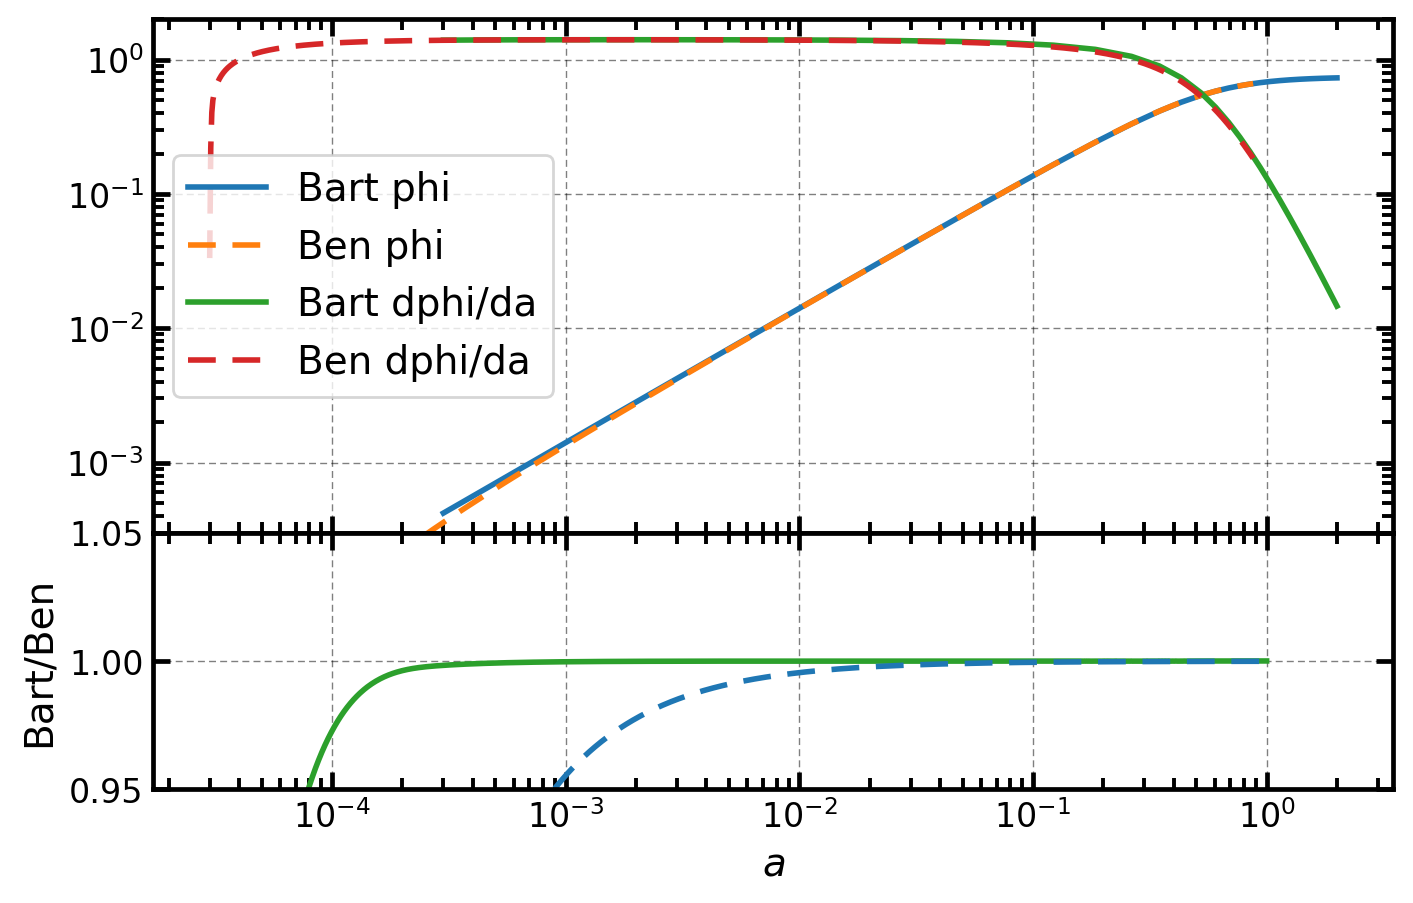

In [51]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][0]), label='Bart phi')
axs[0].plot(df_Ben_BG.a_j, abs(df_Ben_BG['phi']), '--',label='Ben phi' )
axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][1]), label='Bart dphi/da')
axs[0].plot(df_Ben_BG.a_j, abs(df_Ben_BG['d phi/ dlna']/df_Ben_BG.a_j), '--',label='Ben dphi/da' )
# axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylim(a_ini,2)
# axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot((df_Ben_BG['d phi/ dlna'])/H_kmou_sol.sol(df_Ben_BG.a_j)[1]/df_Ben_BG.a_j
            /(1+beta*df_Ben_BG['d phi/ dlna'])
            ,'C2')
axs[1].plot((df_Ben_BG['phi'])/H_kmou_sol.sol(df_Ben_BG.a_j)[0], '--C0' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(0.95,1.05)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'Bart/Ben')
fig.subplots_adjust(hspace=0);

# Jordan frame function

In [162]:
def solve_Kmou_expansion_Jordan(lamb=0.01, beta=0.2, n=2, K0=1, mode='search', H0_target=1, a_ini=3e-5, a_fin=1):
    phi_p, phi_pp, X, rho_m, G = symbols(r'\phi^{\prime}, \phi^{\prime\prime}, X, \rho_m, G')
    phi = Function(r'\phi')(a)
    phi_d, phi_dd = symbols(r'\dot{\phi}, \ddot{\phi}')
    # symbols for system of diff eq
    phi_a = symbols(r'\phi_a')
    
    phi_p = a*H_conf*phi.diff(a)
    phi_pp = a*H_conf*(phi_p).diff(a)
    
    A = exp(beta*phi)
    rho_m = Om*H0_hinvMpc**2/(8*pi*G/3) # convert rho_m into Om
    rho_m0 = Om0_val*H0_hinvMpc**2/(8*pi*G/3) 
    phi_d = phi_p/a
    phi_dd = phi_pp/a**2 - phi_p/a**2*H_conf
    
    K = (-1 + X + K0*X**n)
    K_x = K.diff(X)
    K_xx = K_x.diff(X)
    X_bar = A**2 * phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
    K_bar = K.subs(X, X_bar)
    K_x_bar = K_x.subs(X, X_bar)
    K_xx_bar = K_xx.subs(X, X_bar)
    
    M_pl = 1/sqrt(8*pi*G) 
    rho_phi = M_pl**2 * H0_hinvMpc**2 *lamb**2 / A**4 * (2*X_bar*K_x_bar - K_bar)
    p_phi = M_pl**2 * H0_hinvMpc**2 *lamb**2 / A**4 * (K_bar)
    O_phi = rho_phi/(3*H0_hinvMpc**2*M_pl**2)

    eps2 = a*beta*phi.diff(a)
    eps1 = 2*beta**2/K_x_bar
    
    E_kmou_sq = A**2/(1-eps2)**2 * (Om + O_phi)
    E_kmou = solve(E_kmou_sq - E**2, E)[1]
    E_kmou_a = - 3/2*H0_hinvMpc/H_conf* (A**2 / (1-eps2) *(Om + (rho_phi + p_phi)/(3*M_pl**2 *H0_hinvMpc**2)) + 
                                    2*A**2/(3*(1-eps2)**2)*(eps2 - 1/(1-eps2)*a*eps2.diff(a))*(Om + O_phi) )

    dphia_o_da_sym_eq = H_conf * (A**(-2) * a**3 *H_conf *phi.diff(a)* K_x_bar).diff(a) + beta*rho_m0/M_pl**2
    dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E.diff(a), E_kmou_a)
    dphia_o_da_sym_eq = solve(dphia_o_da_sym_eq.subs(phi.diff(a), phi_a), Derivative(phi_a, a))[0]
    dphia_o_da_sym_eq = dphia_o_da_sym_eq.subs(E, E_kmou).subs(phi.diff(a), phi_a)
    
    dphi_o_da_eq = lambdify((a, phi, phi_a), phi_a)
    dphia_o_da_eq = lambdify((a, phi, phi_a), dphia_o_da_sym_eq)

    def dum_fun(t,vec):
        '''Dummy function to adapt the input of solve_ivp'''
        return (dphi_o_da_eq(t,vec[0],vec[1]),
                dphia_o_da_eq(t,vec[0],vec[1]))

    # Compute the solution of the differential equation
    H_kmou_sol = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-1*a_ini*1e-15, -1), dense_output=True, 
                           rtol=1e-9,atol=1e-9,
                      method='LSODA'
                          )
    if mode=='search':
        E_kmou_fun =lambdify((a, phi, phi_a), E_kmou.subs(phi.diff(a), phi_a))
        return np.array(E_kmou_fun(1, H_kmou_sol.sol(1)[0], H_kmou_sol.sol(1)[1]) - H0_target)/H0_target
    elif mode=='phi':
        return H_kmou_sol
    elif mode=='full':
        E_kmou_fun =lambdify((a, phi, phi_a), E_kmou.subs(phi.diff(a), phi_a))
        E_kmou_a_fun =lambdify((a, phi, phi_a), E_kmou_a_eq.subs(X, X_bar).subs(phi.diff(a),phi_a).subs(E,E_kmou).subs(phi.diff(a), phi_a))
        return H_kmou_sol, E_kmou_fun, E_kmou_a_fun

In [76]:
from scipy.optimize import newton

In [77]:
a_ini=3e-5
best_lamb_J = newton(lambda l: solve_Kmou_expansion_Jordan(l, a_ini=a_ini, beta=0.2, K0=1, n=2), 1.4,maxiter=5)

KeyboardInterrupt: 

In [163]:
H_kmou_sol, E_kmou_fun, E_kmou_a_fun = solve_Kmou_expansion_Jordan(10, beta=0.2, K0=1, n=3, mode='full', a_ini=3e-5)


KeyboardInterrupt



In [77]:
E_3p55 = np.array([E_kmou_fun(t,f,f_p) 
                   for t,f,f_p in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1])])

E_3p55_Ben = np.array([E_kmou_fun(t,f,f_p) for 
                   t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

In [78]:
E_3p56 = np.array([E_kmou_a_fun(t,f,f_p) 
                   for t,f,f_p in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1])])

E_3p56_Ben = np.array([E_kmou_a_fun(t,f,f_p) for 
                   t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

<>:5: SyntaxWarning: invalid escape sequence '\L'
<>:5: SyntaxWarning: invalid escape sequence '\L'
/var/folders/_0/rw1qxx2x3ss_l_mx90qfbv740000gn/T/ipykernel_71136/4121226607.py:5: SyntaxWarning: invalid escape sequence '\L'
  axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k--', label='$\Lambda$CDM')


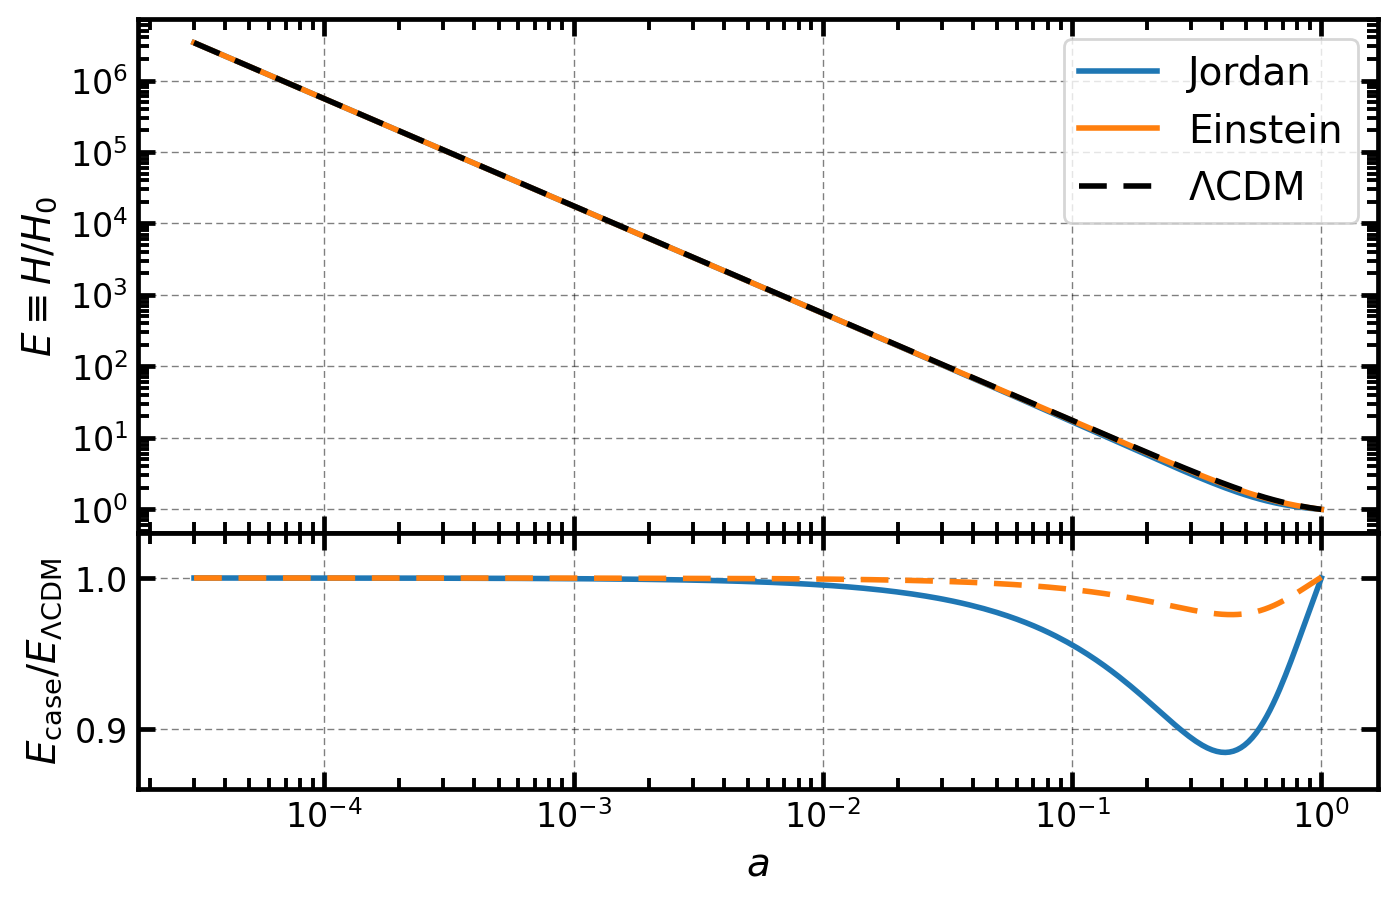

In [84]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], E_3p55, label='Jordan')
axs[0].plot(df_Ben_BG.index, df_Ben_BG['H_MG'], label='Einstein' )
# axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")
axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k--', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot(H_kmou_sol['t'], E_3p55/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label='Jordan')
axs[1].plot(df_Ben_BG.index, df_Ben_BG['H_MG']/lambdify(a,H_LCDM)(df_Ben_BG.index)*H0_hinvMpc, '--',label='Einstein' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
axs[1].set_ylim(0.86,1.03)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
fig.subplots_adjust(hspace=0);

### Hi-COLA approach

In [64]:
from HiCOLA.Frontend import expression_builder as eb

In [1332]:
in_dict = {}
in_dict['G3'] = -3*A.diff(phi)/A**3
in_dict['G4'] = 1/(2*A**2)
in_dict['K'] = K/A**4+ 6*X/A**5*(2*A.diff(phi)**2/A-A.diff(phi).diff(phi))

In [1333]:
Eprime = symbols('E^{\prime}')

In [1334]:
E_kmou_sq = eb.omega_phi(in_dict['G3'], in_dict['G4'], 
          in_dict['K'], E, E_prime, *[1,1,1,1,1,1],omegar=0, phi=phi, 
                                    phiprime=phi_p, omegal=0, omegam=Om0_val)[0]+Om/E**2-1

In [1335]:
E_kmou = solve(E_kmou_sq.subs(X, X_bar), E)[1].subs(phi.diff(a),phi_a).simplify()

In [1336]:
E_prime_E = eb.EprimeEODERHS(in_dict['G3'], in_dict['G4'], 
          in_dict['K'], E, Eprime, omegar=0, omegal=0)[0].subs('M_{KG4}',1)

E_prime /E = a*H_conf dE/da

In [1337]:
E_kmou_a = (nsimplify(E_prime_E/(a*H_conf))).simplify().subs(X, X_bar).subs(E, E_kmou).simplify()

In [1338]:
kmou_back =( eb.phiprimeprimeODERHS(in_dict['G3'], in_dict['G4'], 
          in_dict['K'], E, E_prime, *[1,1,1,1,1,1],omegar=0, phi=phi, 
                                    phiprime=phi_p).subs(X, X_bar).subs(E_prime, E*E_prime_E) -phi_pp)

In [1339]:
dphia_o_da_sym_eq = solve(kmou_back.subs(phi.diff(a),phi_a),Derivative(phi_a,a)
                         )[0].subs(E, E_kmou).subs(E.diff(a),E_kmou_a)

In [1340]:
dphia_o_da_sym_eq = solve(kmou_back.subs(phi.diff(a),phi_a),Derivative(phi_a,a)
                         )[0].subs(E.diff(a),E_kmou_a).subs(E, E_kmou).subs(phi.diff(a),phi_a)

In [1341]:
dphi_o_da_eq = lambdify((a, phi, phi_a), phi_a)
dphia_o_da_eq = lambdify((a, phi, phi_a), dphia_o_da_sym_eq)

def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (dphi_o_da_eq(t,vec[0],vec[1]),
            dphia_o_da_eq(t,vec[0],vec[1]))

# Compute the solution of the differential equation
H_kmou_sol = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(-1.4*a_ini, -1.4), dense_output=True, 
#                        rtol=1e-13,
#                   method='Radau'
                      )

<lambdifygenerated-158227>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 3.23896472118485e-19*Dummy_341415**9*a**6*(-9.36619695591806e+32*Dummy_341415**2*((-0.0724755053258147*Dummy_341415**2*a**2 - sqrt(-0.0357413089755737*Dummy_341415**4*a**4 - 0.0379891470725617*Dummy_341415**4*a*exp(0.4*_Dummy_341414) - 0.144951010651629*Dummy_341415**2*a**2*exp(0.4*_Dummy_341414) + 0.034208394216738*Dummy_341415**2*a**2*exp(0.8*_Dummy_341414) + exp(0.8*_Dummy_341414) - 0.471999388799756*exp(1.2*_Dummy_341414) + 0.0556958557568357*exp(1.6*_Dummy_341414)) + exp(0.4*_Dummy_341414) - 0.235999694399878*exp(0.8*_Dummy_341414))/Dummy_341415**4)**(5/2)*exp(0.4*_Dummy_341414)/a**8 - 7.75e+29 - 2.03645957208381e+32*((-0.0724755053258147*Dummy_341415**2*a**2 - sqrt(-0.0357413089755737*Dummy_341415**4*a**4 - 0.0379891470725617*Dummy_341415**4*a*exp(0.4*_Dummy_341414) - 0.144951010651629*Dummy_341415**2*a**2*exp(0.4*_Dummy_341414) + 0.034208394216738*Dummy_341415**2*a**2*exp(0.8*_Dumm

KeyboardInterrupt: 

In [ ]:
H_kmou_sq = 8*pi*G/3*(A*rho_m)+(1/3*K_x*phi_d**2 - 1/3*lamb**2*K*H0_hinvMpc**2) -H**2

E_kmou_sqrt = solve(H_kmou_sq.subs(X, X_bar), E)[1]

E_3p55 = np.array([lambdify((a, phi, phi_a), E_kmou_sqrt.subs(Derivative(phi, a), phi_a))(t,f,f_p) 
                   for t,f,f_p in zip(H_kmou_sol['t'], H_kmou_sol['y'][0], H_kmou_sol['y'][1])])

E_3p55_Ben = np.array([lambdify((a, phi, phi_a), E_kmou_sqrt.subs(Derivative(phi, a), phi_a))(t,f,f_p) for 
                   t,f,f_p in zip(df_Ben_BG.index, df_Ben_BG['phi'], df_Ben_BG['d phi/ dlna']/df_Ben_BG.index)])

In [ ]:
fig, axs = plt.subplots(2, height_ratios=[2,1], sharex=True)
axs[0].plot(H_kmou_sol['t'], E_3p55, label='Bart Eq 3.55')
axs[0].plot(df_Ben_BG.index, E_3p55_Ben, label='Ben Eq 3.55' )
# axs[0].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2]), label="Bart's solver")
axs[0].plot(df_Ben_BG.index, lambdify(a,H_LCDM)(df_Ben_BG.index)/H0_hinvMpc, 'k--', label='$\Lambda$CDM')

axs[0].legend();
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$E \equiv H/H_0$')

axs[1].plot(H_kmou_sol['t'], E_3p55/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label='Bart Eq 3.55')
axs[1].plot(df_Ben_BG.index, E_3p55_Ben/lambdify(a,H_LCDM)(df_Ben_BG.index)*H0_hinvMpc, '--',label='Ben Eq 3.55' )
# axs[1].plot(H_kmou_sol['t'], abs(H_kmou_sol['y'][2])/lambdify(a,H_LCDM)(H_kmou_sol['t'])*H0_hinvMpc, label="Bart's solver")
# axs[1].set_ylim(0.8,1.1)
axs[1].set_xlabel(r'$a$')
axs[1].set_ylabel(r'$E_{\rm case}/ E_{\rm \Lambda CDM}$')
fig.subplots_adjust(hspace=0);

# Growth

#### $\Lambda$CDM

The growth equation in LCDM reads:
$$D_{1}'' + \mathcal{H} D_{1}' - \frac{3}{2} \, \Omega_{m} H_{0}^{2} a^{2} D_{1} = 0.$$
It is possible to express the derivatives wrt the conformal time in terms of the scale factor:
$$\frac{d}{d\tau} = a \mathcal{H} \frac{d}{da}$$

In [20]:
# Set up differential equation
diff_eq_LCDM = a*H_conf*(a*H_conf*D(a).diff(a)).diff(a) + a*H_conf**2*D(a).diff(a) \
                -3/2*Om*H0_hinvMpc**2*a**(2)*D(a)

diff_eq_LCDM = diff_eq_LCDM.expand().subs(E, H_LCDM/H0_hinvMpc)

And then solve the differntial equation numerically:

In [21]:
# Split 2nd order differential equation in a system of first order differential equations
x_sym_eq = diff_eq_LCDM.subs(D(a).diff(a),x).subs(D(a),y)
x_eq= lambdify((a,x,y), solve(x_sym_eq, Derivative(x,a))[0])
y_eq = lambdify((a,x,y), x)

def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (x_eq(t,vec[0],vec[1]),y_eq(t,vec[0],vec[1]))

# Compute the solution of the differential equation
D_LCDM = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(1,a_ini), dense_output=True, rtol=1e-9)

In [535]:
# Set up differential equation
diff_eq_kmou = a*H_conf*(a*H_conf*D(a).diff(a)).diff(a) + a*H_conf*(H_conf+beta*phi_p)*D(a).diff(a) \
                -3/2*Om*H0_hinvMpc**2*a**(2)*A*mu_kmou*D(a)

diff_eq_kmou = diff_eq_kmou.expand()

NameError: name 'mu_kmou' is not defined

And then solve the differntial equation numerically:

In [ ]:
# Split 2nd order differential equation in a system of first order differential equations
x_sym_eq = diff_eq_kmou.subs(D(a).diff(a),x).subs(D(a),y).subs(E.diff(a),E_diffa)

x_eq= lambdify((a,x,y,E,E_diffa,phi,phi_p), solve(x_sym_eq, Derivative(x,a))[0])
y_eq = lambdify((a,x,y), x)

In [ ]:
def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (x_eq(t,vec[0],vec[1], E_kmou(t),E_diffa_kmou(t), phi_kmou(t), phi_p_kmou(t)),
            y_eq(t,vec[0],vec[1]))

# Compute the solution of the differential equation
D_kmou = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(1,a_ini), dense_output=True, rtol=1e-9)

In [ ]:
plt.plot(df_Ben_BG.index, D_LCDM.sol(df_Ben_BG.index)[1])
plt.plot(df_Ben_BG.index, D_kmou.sol(df_Ben_BG.index)[1])
plt.plot(df_Ben_BG.index, df_Ben_BG.index, 'k--')
plt.xlabel(r'$a_{\rm E}$')
plt.ylabel('$D_+$');

In [ ]:
plt.plot(df_Ben_BG.index, D_LCDM.sol(df_Ben_BG.index)[0], label=r'$\Lambda$CDM')
plt.plot(df_Ben_BG.index, D_kmou.sol(df_Ben_BG.index)[0], label=r'$K$-mouflage')
plt.xlabel(r'$a_{\rm E}$')
plt.ylabel('$f$');
plt.legend();

# Frame transformation

In the Einstein frame the scalar field is minimally coupled with the gravity and the units of lenght are controlled by the conformal factor $A(\phi)$ and so they can vary with time. 

In the Jordan frame the scalar field has non-minimal coupling with gravity but the units are time-independent.

(see Francfurt et al 1907.03606)

Convention:
- no tilde for Einstein frame
- tilde for Jordan frame

The Hubble paramteter tranforms between the two frames like:
$$\tilde{\mathcal{H}} = \mathcal{H}-\frac{\dot{\phi} F^{\prime}}{2 F}$$
where $\dot{\phi} = \frac{d\phi}{d\tau}$, $F^{\prime} = \frac{d F}{d\phi}$ and $F=1/A^2$.

For the Hubble rate this corresponds to:
$$\tilde{H} = \frac{H}{A} (1 + a \beta \frac{d \phi}{da} )$$

<!-- Also the k-mouflage function $k\equiv (K+1)/X$ transforms as:
$$ k=\frac{3}{16 \pi G}\left(\frac{F^{\prime}}{F}\right)^2+\frac{\tilde{k}}{F}. $$ -->

<!-- or reversing the frames:
$$\tilde{k}= F k -\frac{3 F}{16 \pi G}\left(\frac{F^{\prime}}{F}\right)^2 .$$ -->

# Jordan frame

#### Background

In [ ]:
beta = 0.2

In [ ]:
A_vals = np.e**(beta* df_Ben_BG['phi'])

In [ ]:
a_E_vals = df_Ben_BG.index.values
a_J_vals = a_E_vals*A_vals

In [ ]:
H_J = df_Ben_BG['H_MG']/A_vals * (1 + a_E_vals*beta*phi_diffa_kmou(a_E_vals))

In [ ]:
E_vals_LCDM_J = lambdify((a),H_LCDM/H0_hinvMpc)(a_J_vals)

#### Interpolate

In [ ]:
phi_kmou_J = InterpolatedUnivariateSpline(a_J_vals, df_Ben_BG['phi'], ext=3)
phi_diffa_kmou_J = phi_kmou_J.derivative()
E_kmou_J = InterpolatedUnivariateSpline(a_J_vals, H_J, ext=3)
E_diffa_kmou_J = E_kmou_J.derivative()
phi_p_kmou_J = lambda a: a*(a*E_kmou_J(a)*H0_hinvMpc)*phi_diffa_kmou_J(a)

#### Hubble Ratio

In [ ]:
# plt.plot(a_E_vals, df_Ben_BG['H_MG']/E_vals_LCDM, label='Kmou-E / LCDM-E')
plt.plot(a_E_vals, df_Ben_BG['H_MG']/E_vals_LCDM, 'C1', label='Einstein frame')
plt.plot(a_E_vals, H_J/E_vals_LCDM, '--C2', label='Jordan frame')
plt.xscale('log')
plt.xlim(a_min/margin, a_max*margin)
y_min, y_max = plt.ylim()
# plt.vlines(A_vals.iloc[-1], y_min, y_max, linestyles=':', colors='k')
plt.hlines(1, 0, 1, colors='k', linestyles='--')
plt.xlabel(r'$a_{\rm E}$')
plt.ylabel(r'$H_{K{\rm mou}}/H_{\Lambda {\rm CDM}}$')
plt.legend();
plt.savefig('./figures/n2-beta0p2-k1/HubbleRateRatio.pdf', format='pdf')

In [ ]:
# plt.semilogx(a_E_vals, E_vals_LCDM_J/df_Ben_BG['H_LCDM'], label='LCDM ratio: J / E')
plt.semilogx(a_E_vals, df_Ben_BG['H_MG']/E_vals_LCDM, label='Kmou-E / LCDM-E')
plt.semilogx(a_E_vals, df_Ben_BG['H_MG']/E_vals_LCDM_J, label='Kmou-E / LCDM-J')
# plt.semilogx(a_E_vals, df_Ben_BG['H_MG']/E_vals_LCDM, label='Kmou-E / LCDM-J')
plt.semilogx(a_E_vals, H_J/E_vals_LCDM_J, label='Kmou-J / LCDM-J')
# plt.semilogx(a_E_vals, (1 + a_E_vals*beta*phi_diffa_kmou(a_E_vals)),'--', label=r'$\mathcal{H}_{kmou}^J/\mathcal{H}_{kmou}^E$')
# plt.semilogx(a_E_vals, H_j/E_vals_LCDM_J, label='Kmou-Jordan over LCDM')
y_min, y_max = plt.ylim()
plt.vlines(A_vals.iloc[-1], y_min, y_max, linestyles=':', colors='k')
plt.hlines(1, 0, 1, colors='k', linestyles='--')
plt.legend();

#### $k$-mouflage

The growth equation for the k-mouflage model in the Jordan frame reads:
$$D_{1}'' + \mathcal{H} D_{1}' - \frac{3}{2} \, A^2 \Omega_{m} H_{0}^{2} a^{2} \mu D_{1} = 0,$$
where $\mu = 1+\epsilon_1$, $\epsilon_1 = \frac{2 \beta^2}{K_x}$ and $\Omega_{m}$ is the Einstein frame matter density, hence the presence of the $A^2$ factor to take into account the running of the Planck mass in the Jordan frame and how densities transform between the two frames.

The conformal factor is given by 
$$A(\varphi)= \exp \left(\beta_{\mathrm{Kmo}} \varphi\right),$$
$$\frac{\mathrm{d} \ln A(\varphi)}{\mathrm{d} \varphi}=\beta_{\mathrm{Kmo}}.$$

We use the Einstein frame model:
$$K(X)=-1+X+K_0 X^n$$
<!-- is translated in the Jordan frame as:
$$\tilde{K}= X \tilde{k} -1 = X -1 = -1+X+K_0 X^n$$ -->

with $n=2$ and $K_0=1$. Furthermore, we fix $\beta_{\mathrm{Kmo}}=0.2$. Hence, we have 
$$A(\varphi)=\exp \left(0.2 \varphi\right),$$
$$K_X(\bar{X}) = 1 + 2\bar{X} = 1 + \frac{A^2 \bar{\varphi}^{\prime 2}}{\lambda^2 a^2 H_0^2}.$$
where $\lambda=1.476$ is necessary to recover the correct value of $H_0$ today.

In [ ]:
# Define kmouflage quantities
beta = 0.2
phi, phi_p, X = symbols(r'\phi, \phi^{\prime}, X')
A = exp(beta*phi)

n=2
K0=1
lamb= 1.476
K = -1 + X + K0*X**n
K_x = K.diff(X)
X_bar_J = A**2*phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
# X_bar = phi_p**2/(2*lamb**2 * a**2 * H0_hinvMpc**2)
K_x_bar_J = K_x.subs(X, X_bar_J)
# K_x_bar = K_x.subs(X, X_bar)

mu_kmou_J = 1 + 2*beta**2/(K_x_bar_J)
# mu_kmou = 1 + 2*beta**2/(K_x_bar)

In [ ]:
# Set up differential equation
# diff_eq_kmou_j = a*H_conf*(a*H_conf*D(a).diff(a)).diff(a) + a*H_conf*(H_conf)*D(a).diff(a) \
#                 -3/2*A**2*Om*(H0_hinvMpc)**2*a**(2)*mu_kmou_J*D(a)

diff_eq_kmou_j = a*H_conf*(a*H_conf*D(a).diff(a)).diff(a) + a*H_conf*(H_conf)*D(a).diff(a) \
                -3/2*A**2*Om*(H0_hinvMpc)**2*a**(2)*mu_kmou_J*D(a)

# diff_eq_kmou_j = a*(a*D(a).diff(a)).diff(a) + (2+1/H**2*a*H*H.diff(a))*a*D(a).diff(a) \
#                 -3/2*Om*(H0_hinvMpc/H)**2*mu_kmou_J*D(a)

diff_eq_kmou_j = diff_eq_kmou_j.expand()

And then solve the differntial equation numerically:

In [ ]:
# Split 2nd order differential equation in a system of first order differential equations
x_sym_eq = diff_eq_kmou_j.subs(D(a).diff(a),x).subs(D(a),y).subs(E.diff(a),E_diffa)

x_eq= lambdify((a,x,y,E,E_diffa,phi,phi_p), solve(x_sym_eq, Derivative(x,a))[0])
y_eq = lambdify((a,x,y), x)

In [ ]:
def dum_fun(t,vec):
    '''Dummy function to adapt the input of solve_ivp'''
    return (x_eq(t,vec[0],vec[1], E_kmou_J(t),E_diffa_kmou_J(t), phi_kmou_J(t), phi_p_kmou_J(t)),
            y_eq(t,vec[0],vec[1]))

# Compute the solution of the differential equation
D_kmou_J = solve_ivp(dum_fun, t_span=(a_ini,a_fin), y0=(1,a_ini), dense_output=True, rtol=1e-9)

In [ ]:
plt.semilogx(a_E_vals, lambdify([a, phi, phi_p], mu_kmou_J)(a_J_vals,
                                                              phi_kmou_J(a_J_vals),
                                                              phi_p_kmou_J(a_J_vals)), 
             label=r'coupling, $\mu$')

plt.semilogx(a_E_vals, lambdify([phi], A)(phi_kmou(a_E_vals)), label=r'conformal factor, $A$')

plt.xlabel(r'$a_{\rm E}$')

plt.legend()
plt.xlim(a_min/margin, a_max*margin)
plt.savefig('./figures/n2-beta0p2-k1/MG-effects.pdf', format='pdf')

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(a_E_vals, D_LCDM.sol(a_E_vals)[1], label=r'$\Lambda$CDM')
plt.plot(a_E_vals, D_kmou.sol(df_Ben_BG.index)[1], label='$K$-mou Einstein')
plt.plot(a_E_vals, D_kmou_J.sol(a_J_vals)[1], '--',label='$K$-mou Jordan')
plt.plot(a_E_vals , a_E_vals, 'k--', label='D=a')
plt.xlabel(r'$a_{\rm E}$')
plt.ylabel('$D_+$');
plt.legend();
plt.savefig('./figures/n2-beta0p2-k1/Growth_comp.pdf', format='pdf')

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(a_J_vals, D_LCDM.sol(a_J_vals)[1], label='LCDM')
plt.plot(a_J_vals, D_kmou.sol(df_Ben_BG.index)[1], label='kmou-E')
plt.plot(a_J_vals, D_kmou_J.sol(a_J_vals)[1], '--',label='kmou-J')
plt.plot(a_J_vals , a_J_vals, 'k--', label='D=a')
plt.xlabel(r'$a_{\rm Jord}$')
plt.ylabel('$D_+$');
plt.legend();
plt.savefig('./figures/n2-beta0p2-k1/Growth_comp_Jordan.pdf', format='pdf')

In [ ]:
plt.figure(figsize=(6,4))
plt.hlines(1, 0, 1, colors='k', linestyles='--')
plt.semilogx(a_E_vals, D_kmou.sol(df_Ben_BG.index)[1]/D_LCDM.sol(a_E_vals)[1], 'C1',label=r'Einstein frame')
plt.semilogx(a_E_vals, D_kmou_J.sol(a_J_vals)[1]/D_LCDM.sol(a_E_vals)[1], '--C2',label=r'Jordan frame' )
plt.xlabel(r'$a_{\rm E}$')
plt.ylabel(r'$D_{K \rm mou}/D_{\rm \Lambda CDM}$');
plt.legend();
plt.xlim(a_min/margin, a_max*margin)
plt.savefig('./figures/n2-beta0p2-k1/Growth_ratios.pdf', format='pdf')

### Estimate differences in the power spectrum between frames

In [ ]:
# Check if power spectrum changes between frames depending on scale 
scale_of_interest = 1e-2 # in h/Mpc
delta_phi_over_delta = A*beta*a**2*H0_hinvMpc**2*Om/(K_x_bar)/(scale_of_interest)**2
np.max(lambdify([a, phi, phi_p], delta_phi_over_delta)(a_E_vals, phi_kmou(a_E_vals),
                                                                        phi_p_kmou(a_E_vals)))

# Output

In [ ]:
out_table = np.array([a_E_vals, a_J_vals, E_kmou_J(a_J_vals), E_diffa_kmou_J(a_J_vals), 
                      phi_kmou_J(a_J_vals), phi_p_kmou_J(a_J_vals),
                      lambdify([a, phi, phi_p], mu_kmou_J)(a_J_vals, phi_kmou_J(a_J_vals),
                                                                        phi_p_kmou_J(a_J_vals)),
                     A_vals, D_kmou_J.sol(a_J_vals)[1]]).T

header = 'a_E, a_J, E_J, dE_J/da, phi_J, dphi_J/da, G_eff/G, A_conf, D_kmou'
header =''.join([i.ljust(16) for i in header.split(', ')])

np.savetxt('./Data/Output/n2-beta0p2-k1/out_table.txt', out_table, header=header, fmt='%.6e', delimiter='\t')